<a href="https://colab.research.google.com/github/MeinHserhT/CS14115/blob/main/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC14116 - Changing image background

## Tổng quan
Làm mờ hay thay đổi background (hậu cảnh) là một trong những ứng dụng cần thiết trong bối cảnh hậu đại dịch Covid, khi mà ngày càng nhiều cuộc họp được thực hiện trực tuyến do sự tiện lợi của nó mà người dùng muốn có một không gian họp riêng tư ngay tại nơi mình đang ngồi mà không cần phải di chuyển đến một nơi khác.

Việc thay đổi background được nhóm xác định gồm 2 bước chính:
 1. Xác định phần khung viền bọc xung quanh người.
 2. Tùy theo làm mờ hay thay đổi background mà có thể nhân ma trận để làm mờ hoặc ghép hình người vào một khung cảnh khác.

## Động lực
Chúng tôi thấy việc thay đổi background là một tính năng cần thiết cho các ứng dụng họp online được sử dụng rộng rãi trong thời đại công nghệ hiện nay. Bên cạnh đó nhóm nhận thấy công việc này cũng có thể phân ra thành các bước áp dụng được song song hóa, từ đó cải thiện tốc độ xử lý vấn đề.

## Vì sao cần tăng tốc?
Việc thay đổi background nếu được thực hiện tuần tự trên CPU sẽ làm tốn rất nhiều thời gian do mỗi giây trên video tạo từ rất nhiều khung hình, mà mỗi khung đều có thể được quy về các bước để chạy song song mà CPU không thích hợp để chạy song song. Vì thể chúng tôi mong muốn có thể giả lập lại việc thay đổi background chạy song song trên GPU để tăng tốc quá trình xử lý, từ đó có thể đạt được hiệu năng như các ứng dụng họp online như Zoom, Google Meet, ...

## Khả năng chạy song song
1. Việc xác định khung viền bọc xung quanh người được thực hiện bằng việc đưa các khung hình qua model đã được huấn luyện trước. Mỗi khung hình được đưa qua các tầng của model, mà công việc chính là nhân ma trận nên có thể thực hiện việc song song hóa, từ đó có thể thiết kế để chạy song song.
2. Việc thay đổi background cũng có thể được thực hiện song song do việc xác định phần background sẽ được thực hiện bằng việc nhân với ma trận được xác định ở bước 1, việc thay đổi background mới cũng được thực hiện bằng việc nhân ma trận nên có thể song song hoá.

$\rightarrow$ Do đó có thể thiết kế song song cho toàn bộ quá trình. 

**Input:** Hình ảnh, video người dùng trong các cuộc họp trực tuyến và hình ảnh background người dùng muốn thay thế.

**Output:** Hình ảnh, video đã được thay đổi background.


<img src="https://user-images.githubusercontent.com/50958253/174557063-b2699158-4098-4929-b501-bc23eb55f2b0.png" alt="drawing" width="200"/> + <img src="https://user-images.githubusercontent.com/50958253/174557523-737ec1d9-5514-4a00-9d6f-6b0440eaf718.png" alt="drawing" width="200"/>
 = <img src="https://user-images.githubusercontent.com/50958253/174557505-e5784dcb-51b3-4c77-b6a7-36073d5a4e35.png" alt="drawing" width="200"/>

*Nguồn ảnh*: https://www.youtube.com/watch?v=pBIunR98d5I&t=143s




## Hướng tiếp cận 
Dựa trên 2 bước chính:
1. Cài đặt quá trình feedforward với bộ trọng số đã huấn luyện của mô hình U-Net để giải quyết bài toán human segmentation.

   Các tầng layer chính: Conv2d, BatchNormalization, Activation('relu'), MaxPool2D, Conv2dTranspose, Activation('sigmoid')

   Ngoài ra còn có hàm Concatenation.

2. Thay thế các pixel thuộc lớp background với hình ảnh người dùng muốn thay thế.
 
**Tuần tự:** viết code cho các layer sử dụng numpy.

**Song song:** sử dụng numba để tối ưu hóa code tuần tự.     

![zoom5](https://user-images.githubusercontent.com/47071155/174651030-3d2a6216-8f11-4ee7-953e-9dae594b5348.jpg)
![image](https://drive.google.com/uc?id=12PtDDQ8LEpG1EyGTbuon3d7a0bnkH1Ze)

_Ảnh kết quả khi xác định pixel của người dùng mô hình U-Net_

*Nguồn ảnh*: Google image



### Mô hình U-Net 

Đối với bài toán nhận diện người:
* **Input**: Bức ảnh RGB (256x256x3)
* **Output**: Segmentation mask, kích thước (256x256x1) có giá trị khoảng [0,1] và threshold = 0.5 \
Label người nếu threshold > 0.5

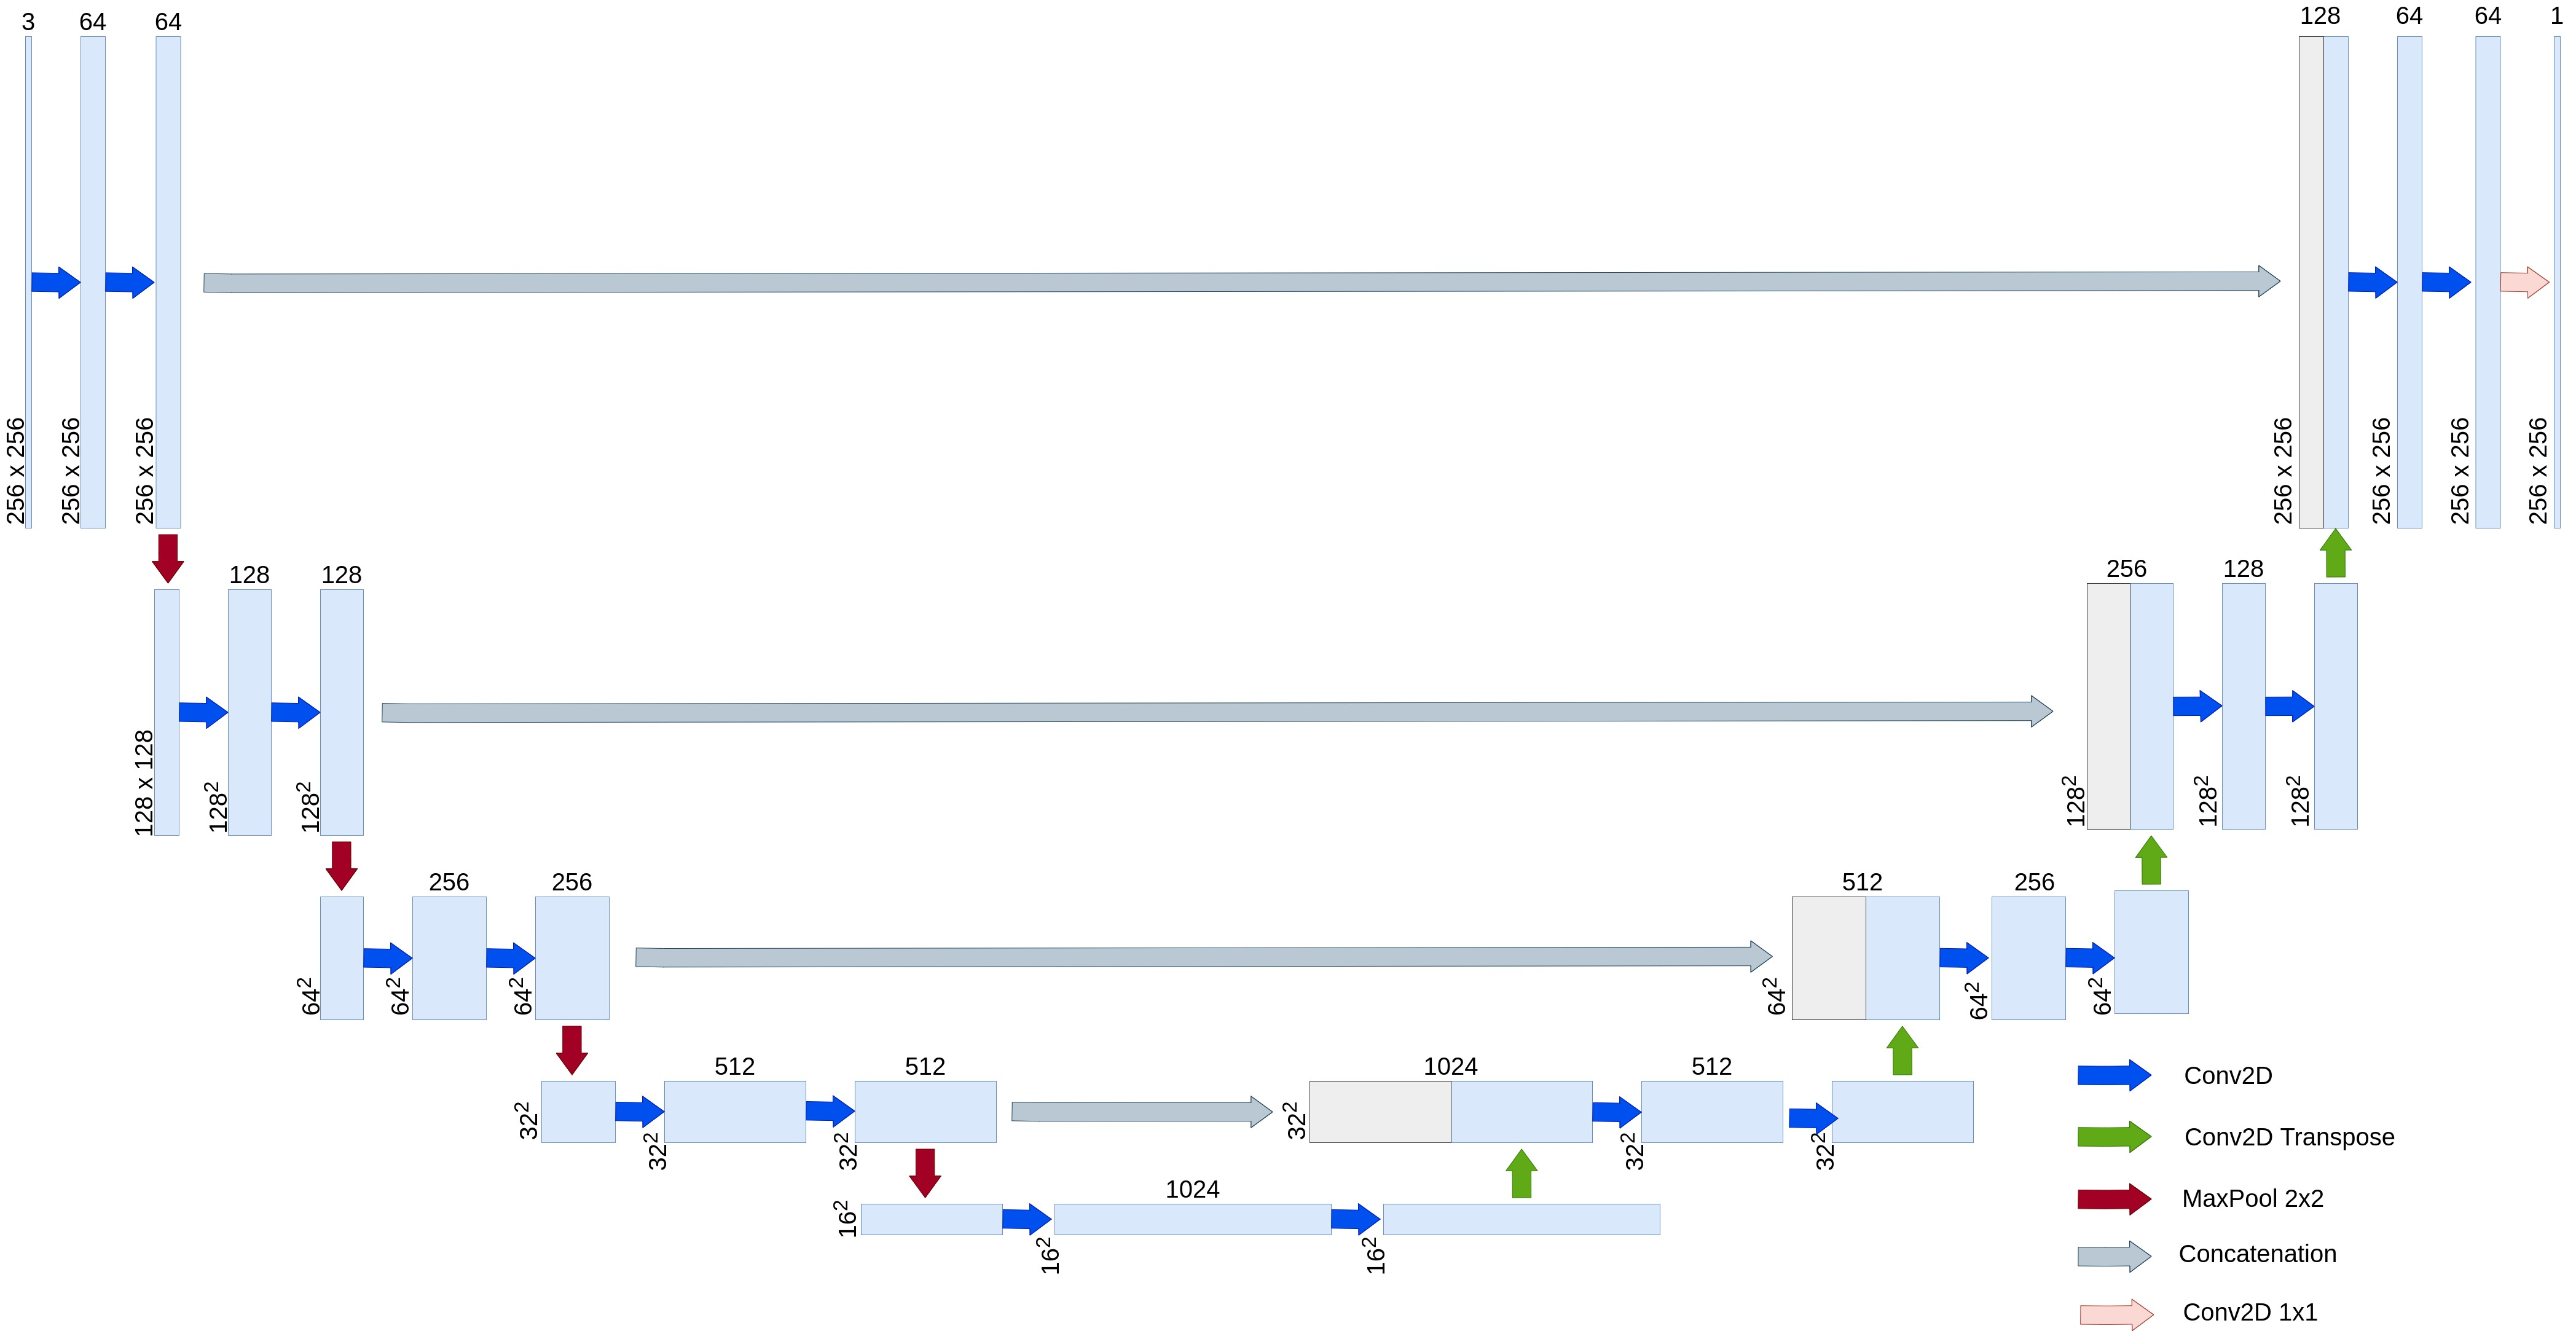

**Bộ dữ liệu**

[Dataset Link](https://www.kaggle.com/datasets/nikhilroxtomar/person-segmentation)
Bộ dữ liệu gồm ảnh chứa người và binary mask. Cấu trúc thư mục:


*   images
*   masks
*   segmentation: chứa các file csv để phân chia tập train, validation




**Thông số huấn luyện**

Nhóm thử nghiệm mô hình trên số lượng epochs = {10, 20, 27} \
Các siêu tham số  dựa trên tham khảo
*   batch_size = 8
*   lr = 1e-4


[Predicted Image Link](https://drive.google.com/drive/folders/1Qf_OD7Pe786e1LqbqnuC9rPAFNmiVUws?usp=sharing) Ảnh dự đoán của mô hình với 3 mức epoch và độ lỗi khi huấn luyện.


## Cài đặt tuần tự
Cài đặt sử dụng dòng lặp và câu điều kiện, không xài các hàm của numpy

### Thiết kế

**Ý tưởng chính:** 
* Tính kích thước và khởi tạo ma trận output.
* Sử dụng 3 vòng lặp tương ứng với depth, width, height để duyệt và tính kết quả cho từng phần tử của ma trận output.



**Activation("relu")** 

Công thức: $f(x) = max(0,x)$ \
* Kích thước ma trận output = input
* Với từng phần tử output: giá trị = 0 nếu x < 0

**MaxPool2D**

MaxPool2D là layer dùng để giảm kích thước của đặc trưng. 

*   Kích thước ma trận output: $O = \frac{I - poolsize}{stride}+1$ \
 $O$ : output's width/ height \
 $I$ : input's width/ height

* Với từng phần tử output: sử dụng 2 dòng for duyệt khu vực filter để tìm được giá trị maximum.

![image.png](https://miro.medium.com/max/1400/1*8yfDolcDtTR7lO88J9crag.png)

> *Nguồn ảnh*: https://medium.com/@PAdhokshaja/simple-cnn-using-numpy-part-iii-relu-max-pooling-softmax-c03a3377eaf2

**Convolution 2D**

Convolution (lớp tích chập) là lớp trích xuất các đặc tính từ hình ảnh. Bằng cách trượt dần bộ lọc theo chiều ngang và dọc trên ảnh, chúng ta sẽ thu được một feature map chứa các đặc trưng được trích xuất từ trên hình ảnh đầu vào. \
*   Kích thước ma trận output: $O = \frac{I - K + 2*padding}{stride}+1$ \
 $O$ : output's width/ height \
 $I$ : input's width/ height \
 $K$ : kernel's width/ height
*   Với từng phần tử output: tính kết quả của phép tích chập ứng với phần tử hiện tại.

<img src="https://i.stack.imgur.com/BZHGo.png" alt="drawing" width="512"/>

> *Nguồn ảnh*: https://stackoverflow.com/questions/43306323/keras-conv2d-and-input-channels

**Transpose Convolution 2D**

> *Tham khảo*: https://d2l.ai/chapter_computer-vision/transposed-conv.html

Lớp Tranpose Convolution là quá trình ngược lại của lớp Convolution. Convolution: biến đổi từ ảnh sang đặc trưng. Tranpose Convolution: biến đổi từ đặc trưng sang các pixel ảnh

Ngoài ra, có thể gia tăng kích thước đặc trưng một cách đơn giản thông qua Upsampling nhưng có thể gây mất mát thông tin. 
*   Kích thước ma trận output: $O = (I - 1)*stride + K + padding$ \
*   Với từng phần tử output: tính phép tích chập đảo cho từng phần tử.

![image.png](https://drive.google.com/uc?id=1wwcnrm_j4Ua_Bs40gZCq537CgsiN4kLm)

> *Tham khảo*: https://d2l.ai/chapter_computer-vision/transposed-conv.html

**Batch Normalization**

Lớp Batch Normalization dùng để chuẩn hóa các giá trị của đặc trưng. Nhóm thao khảo công thức tầng Batch Normalization của [thư viện keras](https://keras.io/api/layers/normalization_layers/batch_normalization/)

* Kích thước ma trận output = input
* Với từng phần tử output: chuẩn hóa giá trị dựa trên công thức dưới đây.

Công thức: 

$$ \frac{\gamma * (x - moving\_mean)}{\sqrt{moving\_var + \epsilon}} + \beta $$

*Các hệ số được cập nhật trong quá trình học*:
* $\gamma$ : hệ số scaling.
* $\beta$ : hệ số offset (xê dịch).
* $\epsilon$ : hằng số nhỏ để đảm bảo chia với số không âm.
* $𝑚𝑜𝑣𝑖𝑛𝑔\_𝑚𝑒𝑎𝑛$ : là tham số mean được học để chuẩn hóa giá trị.
* $𝑚𝑜𝑣𝑖𝑛𝑔\_𝑣𝑎𝑟$ : là tham số variance được học để chuẩn hóa giá trị.





**Concatenation**

Lớp Concatenation dùng để tạo skip-connection giúp cho việc truyền gradient về các lớp đầu tốt hơn. Cải thiện quá trình học của mô hình. 

* Kích thước ma trận output: $(1, InputWidth, InputHeight, InputDepth*2)$
* Với từng phần tử: gán thành giá trị của feature map hoặc skip-features dựa vào chỉ số hiện tại của depth



### Cài đặt

#### Sử dụng thư viện kiểm tra

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/CSC14116-LTSSUD

/content/drive/.shortcut-targets-by-id/1SL0rdRuV7v0Qa3mt_F5k1kFcCa1HCI7I/CSC14116-LTSSUD


In [ ]:
from tensorflow import keras
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Input, MaxPool2D
import numpy as np
import cv2
from keras import backend as K
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

import math
from time import time
from numba import jit, prange, config, cuda, float32
import pandas as pd

In [ ]:
def read_image(path):
    original_img = cv2.imread(path, cv2.IMREAD_COLOR)
    h, w, d = original_img.shape
    x = cv2.resize(original_img, (256, 256))
    x = x/255.0
    x = x.astype(np.float32)
    # (256, 256, 3)
    return x, w, h, original_img

In [ ]:
# Read input and build model
x, x_w, x_h, original_img = read_image("./Images/zoom5.jpg")
x = np.expand_dims(x, axis=0)

In [ ]:
model = tf.keras.models.load_model("./Model_27/unet.h5")

In [ ]:
# Create variables for checking 
from keras import backend as K
inp = model.input                                       # input placeholder
outputs = [layer.output for layer in model.layers]      # all layer outputs
functors = [K.function(inp, out) for out in outputs]    # evaluation functions

# Layers weights
layer_outs = [func(x) for func in functors]

In [ ]:
for i, layer in enumerate(model.layers):
    print(i,layer.name, layer_outs[i].shape)

0 input_2 (1, 256, 256, 3)
1 conv2d_19 (1, 256, 256, 64)
2 batch_normalization_18 (1, 256, 256, 64)
3 activation_18 (1, 256, 256, 64)
4 conv2d_20 (1, 256, 256, 64)
5 batch_normalization_19 (1, 256, 256, 64)
6 activation_19 (1, 256, 256, 64)
7 max_pooling2d_4 (1, 128, 128, 64)
8 conv2d_21 (1, 128, 128, 128)
9 batch_normalization_20 (1, 128, 128, 128)
10 activation_20 (1, 128, 128, 128)
11 conv2d_22 (1, 128, 128, 128)
12 batch_normalization_21 (1, 128, 128, 128)
13 activation_21 (1, 128, 128, 128)
14 max_pooling2d_5 (1, 64, 64, 128)
15 conv2d_23 (1, 64, 64, 256)
16 batch_normalization_22 (1, 64, 64, 256)
17 activation_22 (1, 64, 64, 256)
18 conv2d_24 (1, 64, 64, 256)
19 batch_normalization_23 (1, 64, 64, 256)
20 activation_23 (1, 64, 64, 256)
21 max_pooling2d_6 (1, 32, 32, 256)
22 conv2d_25 (1, 32, 32, 512)
23 batch_normalization_24 (1, 32, 32, 512)
24 activation_24 (1, 32, 32, 512)
25 conv2d_26 (1, 32, 32, 512)
26 batch_normalization_25 (1, 32, 32, 512)
27 activation_25 (1, 32, 32, 512)

In [ ]:
def check(func, *arg):
    start = time()
    result = func(*arg)
    end = time()
    t = end - start
    return result, t

time_compile = np.zeros(7, dtype=float)
time_run = np.zeros(7, dtype=float)
time_unet = np.zeros(7, dtype=float)
time_parallel = np.zeros(7, dtype=float)
func = ['Relu', 'Sigmoid', 'Maxpool2D', 'Conv2D',
        'Conv2D Transpose', 'Batch Norm', 'Concat']

#### Activation("relu")

In [ ]:
@jit(cache=True)
def relu(x):
    for d in range(x.shape[3]):
        for i in range(x.shape[1]):
            for j in range(x.shape[2]):
                if x[0,i,j,d]<0:
                    x[0,i,j,d]=0
    return x

In [ ]:
# Check  answer
before = np.array(layer_outs[2])
after = np.array(layer_outs[3])

i = 0
res, t = check(relu, before)
time_compile[i] += t
print("Checking difference:", np.abs(res-after).mean())

Checking difference: 0.0


In [ ]:
_, t = check(relu, before)
time_run[i] += t

#### Activation("sigmoid")

In [ ]:
@jit(cache=True)
def sigmoid(x):
    for d in range(x.shape[3]):
        for i in range(x.shape[1]):
            for j in range(x.shape[2]):
                x[0,i,j,d]= 1 / (1 + np.exp(-x[0,i,j,d]))
    return x 

In [ ]:
before = np.array(layer_outs[2])
after = 1 / (1 + np.exp(-layer_outs[2]))

i += 1
res, t = check(sigmoid, before)
time_compile[i] += t
print("Checking difference:", np.abs(res-after).mean())

Checking difference: 1.3643426e-08


In [ ]:
_, t = check(sigmoid, before)
time_run[i] += t

#### MaxPool2D

In [ ]:
@jit(cache=True)
def maxpool2d(x, pool_size = 2,stride = 2):
    # Input dim (1,256,256,3)
    output_width = output_height = int((x.shape[1]-pool_size)/stride)+1
    pooled = np.zeros((1,output_width,output_height,x.shape[3]))

    # Iterate over all pools
    for d in range(x.shape[3]):
        for i in range(0,x.shape[1], stride):
            for j in range(0, x.shape[2], stride):
                if i+pool_size <= x.shape[1] and j+pool_size <= x.shape[1]:
                    mat = x[:,i:i+pool_size, j:j+pool_size, d]
                    pooled[:,int(i/stride),int(j/stride),d]=np.max(mat)
                else:
                    raise Exception("Out of index")  
    return pooled

In [ ]:
# Check  answer
before = np.array(layer_outs[6])
after = np.array(layer_outs[7])

i += 1
res, t = check(maxpool2d, before)
time_compile[i] = t
print("Checking difference:", np.abs(res-after).mean())

Checking difference: 0.0


In [ ]:
_, t = check(maxpool2d, before)
time_run[i] = t

#### Conv2D

In [ ]:
@jit(cache=True)
def conv2D(input, wei, bias, padding='valid', stride=1):
    w_in, h_in, c_in = input.shape[1], input.shape[2], input.shape[3]
    k = wei.shape[1] # kernel size
    pad = k // 2 if (padding == 'same') else 0
    w_out = (w_in + 2 * pad - k)//stride + 1
    h_out = (h_in + 2 * pad - k)//stride + 1
    c_out = bias.shape[0]

    input_pad = np.zeros((1, w_in + 2 * pad, h_in + 2 * pad, c_in))
    input_pad[0, pad:(w_in + pad), pad:(h_in + pad), :] = input

    res=np.zeros((1, w_out, h_out, c_out))

    for x in range(w_out): 
        for y in range(h_out):
            for c_o in range(c_out):
                total=0.
                for c_i in range(c_in):
                    kt=0.
                    for k_x in range(k):
                        for k_y in range(k):
                            pos1 = k_x + x * stride
                            pos2 = k_y + y * stride
                            kt += (wei[k_x, k_y, c_i, c_o]
                                        * input_pad[0, pos1, pos2, c_i])
                    total += kt
                res[0, x, y, c_o] = total + bias[c_o]
    return res

In [ ]:
before = np.array(x)
after = np.array(layer_outs[1])
weight = model.layers[1].weights[0].numpy()
bias = model.layers[1].weights[1].numpy()

i += 1
res, t = check(conv2D, before, weight, bias, 'same')
time_compile[i] = t
print("Checking difference:", np.abs(res-after).mean())

Checking difference: 9.781553105755692e-09


In [ ]:
_, t= check(conv2D, before, weight, bias, 'same')
time_run[i] = t

#### Conv2D Transpose

In [ ]:
@jit(cache=True)
def conv2Dtranspose(input, wei, bias, padding='none', stride=1):
    w_in, h_in, c_in = input.shape[1], input.shape[2], input.shape[3]
    k = wei.shape[1] # kernel size

    w_out = w_in*stride
    h_out = h_in*stride
    c_out = bias.shape[0]
    res = np.zeros((1, w_out, h_out, c_out))

    for c_o in range(c_out):
        for x in range(w_in): 
            for y in range(h_in):
                ker = np.zeros((k, k))
                for c_i in range(c_in):
                    for k_x in range(k):
                        for k_y in range(k):
                            ker[k_x, k_y] += (wei[k_x, k_y, c_o, c_i]
                                                    * input[0, x, y, c_i])
                res[0, x*stride: x*stride + k, 
                    y*stride: y*stride + k, c_o] += ker + bias[c_o]
    return res

In [ ]:
before = np.array(layer_outs[34])
after = np.array(layer_outs[35])
weight = model.layers[35].weights[0].numpy()
bias = model.layers[35].weights[1].numpy()

i += 1
res, t = check(conv2Dtranspose, before, weight, bias, "same", 2)
time_compile[i] = t
print("Checking difference:", np.abs(res-after).mean())

Checking difference: 2.2713723770673506e-07


In [ ]:
_, t= check(conv2Dtranspose, before, weight, bias, "same", 2)
time_run[i] = t

#### Batch Normalization

In [ ]:
@jit(cache=True)
def batchNorm(X, gamma, beta, mov_mean, mov_var):
    eps = 0.001
    Y = X.copy()
    for d in range(X.shape[3]):
        for i in range(X.shape[1]):
            for j in range(X.shape[2]):
                Y[0,i,j,d] = beta[d] + (gamma[d]*(X[0,i,j,d]-mov_mean[d]) 
                                            / np.sqrt(mov_var[d]+eps))
    return Y

In [ ]:
before = np.array(layer_outs[1])
after = np.array(layer_outs[2])

wei = model.layers[2].weights
gamma = wei[0].numpy()
beta = wei[1].numpy()
moving_mean = wei[2].numpy()
moving_var = wei[3].numpy()

i += 1
res, t = check(batchNorm, before, gamma, beta, moving_mean, moving_var)
time_compile[i] = t
print("Checking difference:", np.abs(res-after).mean())

Checking difference: 3.189707e-08


In [ ]:
_, t= check(batchNorm, before, gamma, beta, moving_mean, moving_var)
time_run[i] = t

#### Concatenation

In [ ]:
@jit(cache=True)
def concat(skip_features, x):
    w_in, h_in, c_in = x.shape[1] ,x.shape[2] ,x.shape[3]
    Y = np.zeros((1,w_in, h_in, c_in*2))
    for d in range(Y.shape[3]):
        for i in range(Y.shape[1]):
            for j in range(Y.shape[2]):
              if d<c_in:
                Y[:,i,j,d] = x[:,i,j,d]
              else:
                Y[:,i,j,d] = skip_features[:,i,j,d-c_in]
    return Y

In [ ]:
before = np.array(layer_outs[59])
after = np.array(layer_outs[60])

i += 1
res, t = check(concat, np.array(layer_outs[6]), before)
time_compile[i] = t
print("Checking difference:", np.abs(res-after).mean())

Checking difference: 0.0


In [ ]:
_, t = check(concat, np.array(layer_outs[6]), before)
time_run[i] = t

#### Mô hình U-Net
> Tham khảo: 
https://www.kaggle.com/code/kiranshahi/unet-implementation/notebook



In [ ]:
# load weight to dictionary
weights = {}
for i, layer in enumerate(model.layers):
    if "conv2d_transpose" in layer.name: 
        weights[i] = {"name":layer.name,
                      "wei": layer.weights[0].numpy(),
                      "bias": layer.weights[1].numpy()} 
    elif "conv2d" in layer.name: 
        weights[i] = {"name":layer.name,
                      "wei": layer.weights[0].numpy(),
                      "bias": layer.weights[1].numpy()}
    elif "batch_normalization" in layer.name:
        weights[i] = {"name":layer.name,
                      "gamma":layer.weights[0].numpy(),
                      "beta":layer.weights[1].numpy(), 
                      "moving_mean":layer.weights[2].numpy(),
                      "moving_var":layer.weights[3].numpy()}
      

In [ ]:
def conv_block(inputs, index):
    x, t = check(conv2D, inputs, weights[index]["wei"], weights[index]["bias"], 'same')
    time_unet[3] += t
    x, t = check(batchNorm, x, weights[index+1]["gamma"], weights[index+1]["beta"], weights[index+1]["moving_mean"], weights[index+1]["moving_var"])
    time_unet[5] += t
    x, t = check(relu, x)
    time_unet[0] += t

    index += 3
    x, t = check(conv2D, x, weights[index]["wei"], weights[index]["bias"], 'same')
    time_unet[3] += t
    x, t = check(batchNorm, x, weights[index+1]["gamma"], weights[index+1]["beta"], weights[index+1]["moving_mean"], weights[index+1]["moving_var"])
    time_unet[5] += t
    x, t = check(relu, x)
    time_unet[0] += t
    
    return x

In [ ]:
def encoder_block(inputs, index):
    print("encoder_block", index)
    x = conv_block(inputs, index)
    p, t = check(maxpool2d, x)
    time_unet[2] += t
    return x, p

In [ ]:
def decoder_block(inputs, skip_features, index):
    print("decoder_block",index)
    x, t = check(conv2Dtranspose, inputs, weights[index]["wei"], weights[index]["bias"], "same", 2)
    time_unet[4] += t
    x, t = check(concat, skip_features, x)
    time_unet[6] += t
    x = conv_block(x, index + 2)
    return x

In [ ]:
def build_unet(X):
    index = 1
    """ Encoder """
    s1, p1 = encoder_block( X, index ) #64
    index += 7
    s2, p2 = encoder_block( p1, index ) #128
    index += 7
    s3, p3 = encoder_block( p2, index ) #256
    index += 7
    s4, p4 = encoder_block( p3, index ) #512
    index += 7
    b1 = conv_block( p4, index ) #1024
    index += 6
    """ Decoder """
    d1 = decoder_block( b1, s4, index ) #512
    index += 8
    d2 = decoder_block( d1, s3, index ) #256
    index += 8
    d3 = decoder_block( d2, s2, index ) #128
    index += 8
    d4 = decoder_block( d3, s1, index ) #64 
    index += 8

    """ Output """
    # outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    flatten, t = check(conv2D, d4, weights[index]["wei"], weights[index]["bias"], "same", 1)
    time_unet[3] += t
    outputs, t = check(sigmoid, flatten)
    time_unet[1] += t
    return outputs

In [ ]:
%time pred = build_unet(x)

encoder_block 1
encoder_block 8
encoder_block 15
encoder_block 22
decoder_block 35
decoder_block 43
decoder_block 51
decoder_block 59
CPU times: user 6min 15s, sys: 1.01 s, total: 6min 16s
Wall time: 6min 27s


#### Thay đổi background

In [ ]:
@jit(cache=True)
def change_bg(result, mask, background, width, height, mode):
    for w in range(width):
        for h in range(height):
            if mask[h, w] <= 0.5:
                for c in range(3):
                    if mode == 0:
                        result[h, w, c] = 0
                    elif mode == 1:
                        result[h, w, c] = background[h, w, c]
    return result

In [ ]:
background_path='./Images/background.jpg'
background = cv2.resize(cv2.imread(background_path, cv2.IMREAD_COLOR), (x_w, x_h))
mask = cv2.resize(pred[0], (x_w, x_h))

r = original_img.copy()

%time verify = change_bg(r, mask, background, x_w, x_w, 0)
cv2.imwrite("./Images/sequential.jpg", verify)
result = change_bg(r, mask, background, x_w, x_w, 1)
cv2.imwrite("./Images/sequential_bg.jpg", result)

CPU times: user 197 ms, sys: 0 ns, total: 197 ms
Wall time: 194 ms


True

In [ ]:
%time _ = change_bg(r, mask, background, x_w, x_h, 0)

CPU times: user 2.05 ms, sys: 1 µs, total: 2.05 ms
Wall time: 2.06 ms


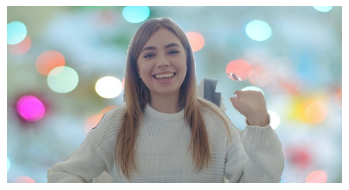

In [ ]:
plt.imshow(cv2.imread("Images/sequential_bg.jpg")[...,::-1]);
plt.axis('off');

### Đánh giá

#### Độ chính xác

Kết quả được feedforward hình qua mô hình tuần tự:



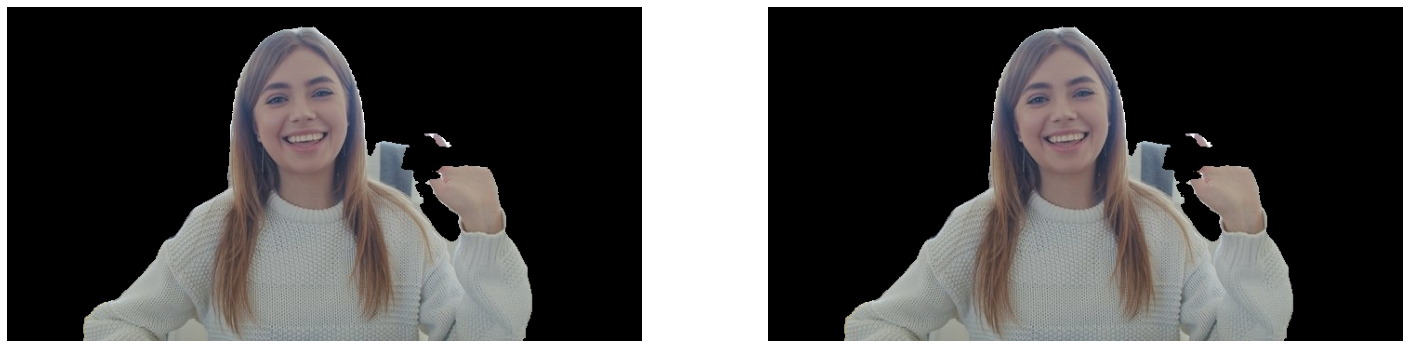

In [ ]:
list_images = [cv2.imread("Images/sequential.jpg")[...,::-1], 
               cv2.imread("Images/unet.jpg")[...,::-1]]
fig = plt.figure(figsize=(25, 20))
fig.add_subplot(1, 2, 1)

# showing image
plt.imshow(list_images[0]);
plt.axis('off');
  
# Adds a subplot at the 2nd position
fig.add_subplot(1, 2, 2)
  
# showing image
plt.imshow(list_images[1]);
plt.axis('off');

In [ ]:
np.abs(list_images[0]-list_images[1]).mean()

0.0

#### Thời gian chạy

In [ ]:
pd.DataFrame(list(zip(func, time_compile, time_run, time_unet)),
               columns =['Name', 'Compile+Run(s)', 'Run(s)', 'Unet(s)']).sort_values(by=['Unet(s)'], ascending=False)

,Name,Compile+Run(s),Run(s),Unet(s)
3,Conv2D,1.231132,0.478337,369.619634
4,Conv2D Transpose,4.281213,3.437281,14.815412
2,Maxpool2D,0.792720,0.062802,0.869897
5,Batch Norm,0.265706,0.050422,0.865302
6,Concat,0.551083,0.249747,0.786266
0,Relu,0.273610,0.021084,0.428666
1,Sigmoid,0.264945,0.073416,0.161476


In [ ]:
print("Tổng thời gian chạy FFW tuần tự: ", round(time_unet.sum(), 6), '(s)')

Tổng thời gian chạy FFW tuần tự:  387.546651 (s)


## Cài đặt song song

### Phân tích 

**Thời gian chạy trung bình:**

*   Chạy với thư viện keras: 2.3s (CPU) và 0.5 (GPU)
*   Chạy tuần tự: 9m 



Nhóm nhận thấy tổng thời gian mô hình U-Net chạy feedforward khá lâu. Để tăng tốc đáng kể thời gian dự đoán của mô hình, nhóm sẽ thực hiện song song cho tất cả các layer. \
Các layer được song song hóa:


1.   Activation ("relu")
2.   Activation ("sigmoid")
3.  MaxPool2D
4. Conv2D
5. Conv2D Transpose
6. Batch Normalization
7. Concatenation



### Thiết kế
**Ý tưởng chính**: Với output có kích thước $w' \times h' \times d'$, mỗi thread sẽ thực hiện tính giá trị cho từng phần tử của ma trận output.

### Cài đặt

In [ ]:
print(cuda.detect())
BLOCK_SIZE = (8, 8, 8)

time_compile_parallel = np.zeros(7, dtype=float)
time_run_parallel = np.zeros(7, dtype=float)
time_unet_parallel = np.zeros(7, dtype=float)

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-d3d9e576-4c85-d1c7-8470-cb51f49e576f
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported
True


#### Activation("relu")

In [ ]:
@cuda.jit(debug=True) 
def relu_parallel(input, output):
    x, y, z = cuda.grid(3)

    if x < output.shape[1] and y < output.shape[2] and z < output.shape[3]:
        if input[0, x, y, z] < 0: 
            output[0, x, y, z] = 0
        else: output[0, x, y, z] = input[0, x, y, z]

/usr/local/lib/python3.7/dist-packages/numba/cuda/decorators.py:80: NumbaInvalidConfigWarning: debug=True with opt=True (the default) is not supported by CUDA. This may result in a crash - set debug=False or opt=False.
  warn(NumbaInvalidConfigWarning(msg))


In [ ]:
def relu_host(before):
    res = np.zeros((before.shape), dtype=float)
    
    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))
    relu_parallel[GRID_SIZE, BLOCK_SIZE](before, res)
    return res

In [ ]:
before = np.array(layer_outs[2])
after = np.array(layer_outs[3])

In [ ]:
i=0
res, t = check(relu_host, before)
time_compile_parallel[i] += t
print("Checking difference", np.abs(res-after).mean())  

Checking difference 0.0


/usr/local/lib/python3.7/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function relu_parallel at 0x7f54f383db00>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: relu_parallel)
  warn(NumbaInvalidConfigWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [ ]:
res, t = check(relu_host, before)
time_run_parallel[i] += t

#### Activation("sigmoid")

In [ ]:
@cuda.jit(debug=True) 
def sigmoid_parallel(input, output):
    x, y, z = cuda.grid(3)

    if x < output.shape[1] and y < output.shape[2] and z < output.shape[3]:
        output[0, x, y, z] = 1 / (1 + math.exp(-input[0, x, y, z]))

/usr/local/lib/python3.7/dist-packages/numba/cuda/decorators.py:80: NumbaInvalidConfigWarning: debug=True with opt=True (the default) is not supported by CUDA. This may result in a crash - set debug=False or opt=False.
  warn(NumbaInvalidConfigWarning(msg))


In [ ]:
def sigmoid_host(before):
    res = np.zeros((before.shape), dtype=float)
    
    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))
    sigmoid_parallel[GRID_SIZE, BLOCK_SIZE](before, res)
    return res

In [ ]:
before = np.array(layer_outs[2])
after = 1 / (1 + np.exp(-layer_outs[2]))

In [ ]:
i+=1
res, t = check(sigmoid_host, before)
time_compile_parallel[i] += t
print("Checking difference",np.abs(res-after).mean())

/usr/local/lib/python3.7/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function sigmoid_parallel at 0x7f554a0549e0>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: sigmoid_parallel)
  warn(NumbaInvalidConfigWarning(msg))


Checking difference 1.9631155042829085e-08


/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [ ]:
res, t = check(sigmoid_host, before)
time_run_parallel[i] += t

#### MaxPool2D

In [ ]:
@cuda.jit(debug=True)
def maxpool2d_parallel(input, output, pool, stride):
    x, y, z = cuda.grid(3)

    if x < output.shape[1] and y < output.shape[2] and z < output.shape[3]:
        col = x * stride
        row = y * stride

        max = input[0, col, row, z]
        for i in range(pool):
            for j in range(pool):
                if input[0, col + i, row + j, z] > max:
                    max = input[0, col + i, row + j, z]

        output[0, x, y, z] = max

/usr/local/lib/python3.7/dist-packages/numba/cuda/decorators.py:80: NumbaInvalidConfigWarning: debug=True with opt=True (the default) is not supported by CUDA. This may result in a crash - set debug=False or opt=False.
  warn(NumbaInvalidConfigWarning(msg))


In [ ]:
def maxpool2d_host(before, pool = 2, stride = 2):
    w_out = (before.shape[1] - pool)//stride + 1
    h_out = (before.shape[2] - pool)//stride + 1
    res = np.empty((1, w_out, h_out, before.shape[3]), dtype=float)

    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))
    maxpool2d_parallel[GRID_SIZE, BLOCK_SIZE]( before, res, pool, stride)
    return res

In [ ]:
before = np.array(layer_outs[6])
after = np.array(layer_outs[7])

In [ ]:
i+=1
res, t = check(maxpool2d_host, before)
time_compile_parallel[i] += t
print("Checking difference",np.abs(res-after).mean())

/usr/local/lib/python3.7/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function maxpool2d_parallel at 0x7f554acf4290>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: maxpool2d_parallel)
  warn(NumbaInvalidConfigWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Checking difference 0.0


In [ ]:
res , t = check(maxpool2d_host, before)
time_run_parallel[i] += t

#### Conv2D

In [ ]:
@cuda.jit(debug=True)
def conv2D_parallel(input, output, wei, bias, stride):
    x, y, z = cuda.grid(3)

    if x < output.shape[1] and y < output.shape[2] and z < output.shape[3]:
        k = wei.shape[1]
        c_in = input.shape[3]

        total=0.
        for c_i in range(c_in):
            kt=0.
            for k_x in range(k):
                for k_y in range(k):
                    pos1 = k_x + x * stride
                    pos2 = k_y + y * stride
                    kt += wei[k_x, k_y, c_i, z] * input[0, pos1, pos2, c_i]
            total += kt
        
        output[0, x, y, z] = total + bias[z]

/usr/local/lib/python3.7/dist-packages/numba/cuda/decorators.py:80: NumbaInvalidConfigWarning: debug=True with opt=True (the default) is not supported by CUDA. This may result in a crash - set debug=False or opt=False.
  warn(NumbaInvalidConfigWarning(msg))


In [ ]:
def conv2D_host(before, weight, bias ,padding ="same", stride = 1):
    w_in, h_in, c_in = before.shape[1:4]

    k = weight.shape[1]
    pad = k // 2
    w_out = (w_in + 2 * pad - k)//stride + 1
    h_out = (h_in + 2 * pad - k)//stride + 1
    c_out = bias.shape[0]

    input_pad = np.zeros((1, w_in + 2 * pad, h_in + 2 * pad, c_in))
    input_pad[0, pad:(w_in + pad), pad:(h_in + pad), :] = before

    res = np.zeros((1, w_out, h_out, c_out))
    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))
    conv2D_parallel[GRID_SIZE, BLOCK_SIZE](input_pad, res, 
                                            weight, bias, stride)
    return res

In [ ]:
before = np.array(layer_outs[66])
after = np.array(layer_outs[67])
weight = model.layers[67].weights[0].numpy()
bias = model.layers[67].weights[1].numpy()

In [ ]:
i+=1
res,t = check(conv2D_host, before, weight, bias)
# time_compile_parallel[i] += t
print("Checking difference",np.abs(res-after).mean())

/usr/local/lib/python3.7/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function conv2D_parallel at 0x7f554bbb4200>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: conv2D_parallel)
  warn(NumbaInvalidConfigWarning(msg))


Checking difference 5.974340871798924


/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [ ]:
res,t = check(conv2D_host, before, weight, bias)
time_run_parallel[i] += t

#### Conv2D Transpose


In [ ]:
@cuda.jit(debug=True)
def conv2Dtranspose_parallel(input, output, wei, bias, stride):
    x, y, z = cuda.grid(3)

    if x < output.shape[1] and y < output.shape[2] and z < output.shape[3]:
        # k = wei.shape[1]
        c_in = input.shape[3]

        total=0.
        k_x = x % stride
        k_y = y % stride
        for c_i in range(c_in):
            total += wei[k_x, k_y, z, c_i] * input[0, x // stride, y // stride, c_i]
        
        output[0, x, y, z] = total + bias[z]

/usr/local/lib/python3.7/dist-packages/numba/cuda/decorators.py:80: NumbaInvalidConfigWarning: debug=True with opt=True (the default) is not supported by CUDA. This may result in a crash - set debug=False or opt=False.
  warn(NumbaInvalidConfigWarning(msg))


In [ ]:
def conv2Dtranspose_host(before, weight, bias, padding="same", stride = 1):
    w_in, h_in, c_in = before.shape[1:4]

    stride = 2
    k = weight.shape[1]
    w_out = w_in * stride
    h_out = h_in * stride
    c_out = bias.shape[0]

    res = np.zeros((1, w_out, h_out, c_out))
    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))
    conv2Dtranspose_parallel[GRID_SIZE, BLOCK_SIZE](before, res, 
                                                    weight, bias, stride)
    return res

In [ ]:
before = np.array(layer_outs[34])
after = np.array(layer_outs[35])
weight = model.layers[35].weights[0].numpy()
bias = model.layers[35].weights[1].numpy()

In [ ]:
i+=1
res,t = check(conv2Dtranspose_host, before, weight, bias)
time_compile_parallel[i] += t
print("Checking difference",np.abs(res-after).mean())

/usr/local/lib/python3.7/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function conv2Dtranspose_parallel at 0x7f554ab64d40>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: conv2Dtranspose_parallel)
  warn(NumbaInvalidConfigWarning(msg))


Checking difference 2.2713723770673506e-07


/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [ ]:
res,t = check(conv2Dtranspose_host, before, weight, bias)
time_run_parallel[i] += t

#### Batch Normalization

In [ ]:
@cuda.jit(debug=True)
def batchNorm_parallel(X, res, eps, gamma, beta, moving_mean, moving_var):
    i,j,d = cuda.grid(3)

    res[0,i,j,d] = beta[d] + (gamma[d]*(X[0,i,j,d]-moving_mean[d])
                                            / math.sqrt(moving_var[d]+eps))

/usr/local/lib/python3.7/dist-packages/numba/cuda/decorators.py:80: NumbaInvalidConfigWarning: debug=True with opt=True (the default) is not supported by CUDA. This may result in a crash - set debug=False or opt=False.
  warn(NumbaInvalidConfigWarning(msg))


In [ ]:
def batchNorm_host(before, gamma, beta, moving_mean, moving_var):
    # ----
    eps = 0.001
    res = np.empty((before.shape), dtype=float)
    # ----
    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))

    batchNorm_parallel[GRID_SIZE, BLOCK_SIZE](before, res,
                                                eps, gamma, beta, 
                                                moving_mean, moving_var)
    return res

In [ ]:
before = np.array(layer_outs[1])
after = np.array(layer_outs[2])

wei = model.layers[2].weights
gamma = wei[0].numpy()
beta = wei[1].numpy()
moving_mean = wei[2].numpy()
moving_var = wei[3].numpy()

In [ ]:
i+=1
res, t = check(batchNorm_host, before, gamma, beta, moving_mean, moving_var)
time_compile_parallel[i] += t
print("Checking difference",np.abs(res-after).mean())

/usr/local/lib/python3.7/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function batchNorm_parallel at 0x7f554abec3b0>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: batchNorm_parallel)
  warn(NumbaInvalidConfigWarning(msg))


Checking difference 3.3173819904111204e-08


/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [ ]:
res, t = check(batchNorm_host, before, gamma, beta, moving_mean, moving_var)
time_run_parallel[i] += t

#### Concatenation

In [ ]:
@cuda.jit(debug=True)
def concat_parallel(skip_features, x, res):
    i,j,d = cuda.grid(3)
    
    if d<x.shape[3]:
      res[0,i,j,d] = x[0,i,j,d]
    else:
      res[0,i,j,d] = skip_features[0,i,j,d-x.shape[3]]

/usr/local/lib/python3.7/dist-packages/numba/cuda/decorators.py:80: NumbaInvalidConfigWarning: debug=True with opt=True (the default) is not supported by CUDA. This may result in a crash - set debug=False or opt=False.
  warn(NumbaInvalidConfigWarning(msg))


In [ ]:
def concat_host(skip_features, before):
  w_in, h_in, c_in = before.shape[1], before.shape[2], before.shape[3]
  res = np.zeros((1, w_in, h_in, c_in*2))

  GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
              math.ceil(res.shape[2]/BLOCK_SIZE[1]),
              math.ceil(res.shape[3]/BLOCK_SIZE[2]))
  concat_parallel[GRID_SIZE, BLOCK_SIZE]( skip_features, before,res)
  return res

In [ ]:
before = np.array(layer_outs[59])
after = np.array(layer_outs[60])
skip_features = np.array(layer_outs[6])

In [ ]:
i+=1
res,t = check(concat_host, skip_features, before)
time_compile_parallel[i] += t
print("Checking difference:", np.abs(res-after).mean())

/usr/local/lib/python3.7/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function concat_parallel at 0x7f554b9b4a70>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: concat_parallel)
  warn(NumbaInvalidConfigWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Checking difference: 0.0


In [ ]:
res,t = check(concat_host, skip_features, before)
time_run_parallel[i] += t

#### Mô hình U-Net song song
> Tham khảo: 
https://www.kaggle.com/code/kiranshahi/unet-implementation/notebook



In [ ]:
# load weight to dictionary
weights = {}
for i, layer in enumerate(model.layers):
    if "conv2d_transpose" in layer.name: 
        weights[i] = {"name":layer.name, "wei": layer.weights[0].numpy(),"bias": layer.weights[1].numpy()} 
    elif "conv2d" in layer.name: 
        weights[i] = {"name":layer.name, "wei": layer.weights[0].numpy(),"bias": layer.weights[1].numpy()}
    elif "batch_normalization" in layer.name:
        weights[i] = {"name":layer.name,
                      "gamma":layer.weights[0].numpy(),
                      "beta":layer.weights[1].numpy(), 
                      "moving_mean":layer.weights[2].numpy(),
                      "moving_var":layer.weights[3].numpy()}
      

In [ ]:
def conv_block(inputs, index):
    x, t = check(conv2D_host, inputs, weights[index]["wei"], weights[index]["bias"], 'same')
    time_unet_parallel[3] += t
    x, t = check(batchNorm_host, x, weights[index+1]["gamma"], weights[index+1]["beta"], weights[index+1]["moving_mean"], weights[index+1]["moving_var"])
    time_unet_parallel[5] += t
    x, t = check(relu_host, x)
    time_unet_parallel[0] += t

    index += 3
    x, t = check(conv2D_host, x, weights[index]["wei"], weights[index]["bias"], 'same')
    time_unet_parallel[3] += t
    x, t = check(batchNorm_host, x, weights[index+1]["gamma"], weights[index+1]["beta"], weights[index+1]["moving_mean"], weights[index+1]["moving_var"])
    time_unet_parallel[5] += t
    x, t = check(relu_host, x)
    time_unet_parallel[0] += t
    
    return x

In [ ]:
def encoder_block(inputs, index):
    print("encoder_block", index)
    x = conv_block(inputs, index)
    p, t = check(maxpool2d_host, x)
    time_unet_parallel[2] += t
    return x, p

In [ ]:
def decoder_block(inputs, skip_features, index):
    x, t = check(conv2Dtranspose_host, inputs, weights[index]["wei"], weights[index]["bias"], "same", 2)
    time_unet_parallel[4] += t
    x, t = check(concat_host, skip_features, x)
    time_unet_parallel[6] += t
    x = conv_block(x, index + 2)
    return x

In [ ]:
def build_unet(X):
    index = 1
    """ Encoder """
    s1, p1 = encoder_block( X, index ) #64
    index += 7
    s2, p2 = encoder_block( p1, index ) #128
    index += 7
    s3, p3 = encoder_block( p2, index ) #256
    index += 7
    s4, p4 = encoder_block( p3, index ) #512
    index += 7
    b1 = conv_block( p4, index ) #1024
    index += 6
    """ Decoder """
    d1 = decoder_block( b1, s4, index ) #512
    index += 8
    d2 = decoder_block( d1, s3, index ) #256
    index += 8
    d3 = decoder_block( d2, s2, index ) #128
    index += 8
    d4 = decoder_block( d3, s1, index ) #64 
    index += 8

    """ Output """
    # outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    flatten, t = check(conv2D_host, d4, weights[index]["wei"], weights[index]["bias"], "same", 1)
    time_unet_parallel[3] += t
    outputs, t = check(sigmoid_host, flatten)
    time_unet_parallel[1] += t
    return outputs

In [ ]:
%time pred = build_unet(x)

encoder_block 1


/usr/local/lib/python3.7/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function batchNorm_parallel at 0x7f554abec3b0>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: batchNorm_parallel)
  warn(NumbaInvalidConfigWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function relu_parallel at 0x7f54f383db00>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/usr/local/lib/python3.7/dist-packages/num

encoder_block 8
encoder_block 15
encoder_block 22


/usr/local/lib/python3.7/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function conv2Dtranspose_parallel at 0x7f554ab64d40>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: conv2Dtranspose_parallel)
  warn(NumbaInvalidConfigWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function concat_parallel at 0x7f554b9b4a70>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/usr/local/lib/python3.7/dis

CPU times: user 4.49 s, sys: 117 ms, total: 4.61 s
Wall time: 5.51 s


/usr/local/lib/python3.7/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function sigmoid_parallel at 0x7f554a0549e0>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: sigmoid_parallel)
  warn(NumbaInvalidConfigWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


#### Thay đổi background

In [ ]:
# background = cv2.resize(cv2.imread(background_path, cv2.IMREAD_COLOR), (x_W, x_H))
mask = cv2.resize(pred[0], (x_w, x_h))

verify = change_bg(r, mask, background, x_w, x_h, 0)
cv2.imwrite("./Images/parallel.jpg", verify)
result = change_bg(r, mask, background, x_w, x_h, 1)
cv2.imwrite("./Images/parallel_bg.jpg", result)

True

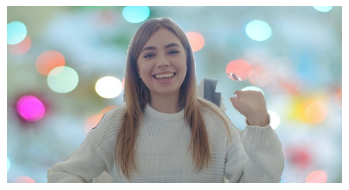

In [ ]:
plt.imshow(cv2.imread("Images/parallel_bg.jpg")[...,::-1]);
plt.axis('off');

### Đánh giá

#### Độ chính xác

Kết quả được feedforward hình qua mô hình tuần tự:



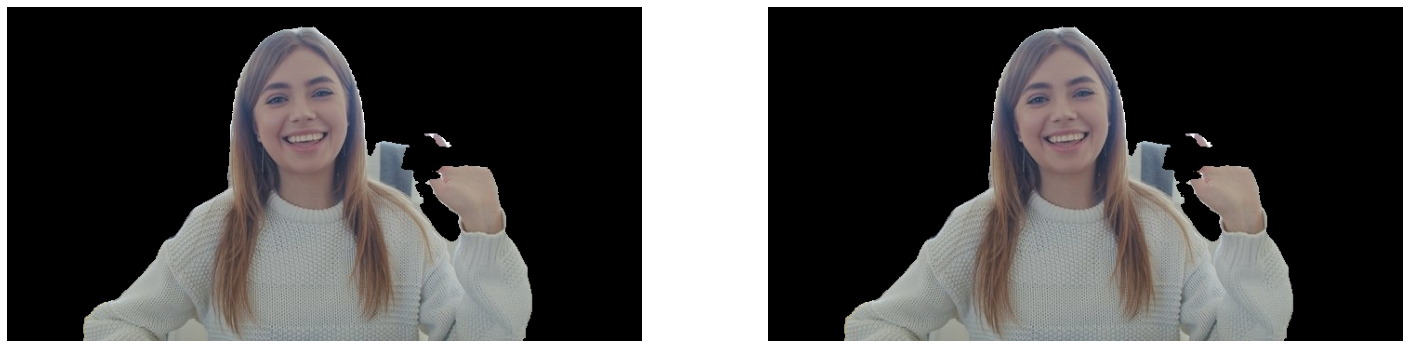

In [ ]:
list_images = [cv2.imread("Images/parallel.jpg")[...,::-1], 
               cv2.imread("Images/unet.jpg")[...,::-1]]
fig = plt.figure(figsize=(25, 20))
fig.add_subplot(1, 2, 1)

# showing image
plt.imshow(list_images[0]);
plt.axis('off');
  
# Adds a subplot at the 2nd position
fig.add_subplot(1, 2, 2)
  
# showing image
plt.imshow(list_images[1]);
plt.axis('off');

In [ ]:
np.abs(list_images[0] - list_images[1]).mean()

0.0

#### Thời gian chạy

In [ ]:
pd.DataFrame(list(zip(func, time_compile_parallel, time_run_parallel, time_unet_parallel)),
               columns =['Name', 'Compile+Run(s)', 'Run(s)', 'Unet(s)']).sort_values(by=['Unet(s)'], ascending=False)

,Name,Compile+Run(s),Run(s),Unet(s)
3,Conv2D,0.000000,0.031022,2.330634
6,Concat,0.252676,0.071248,0.943180
5,Batch Norm,0.310351,0.028790,0.761397
0,Relu,0.527736,0.031551,0.543934
4,Conv2D Transpose,0.374084,0.037725,0.439012
2,Maxpool2D,0.279017,0.026089,0.301879
1,Sigmoid,0.233396,0.029836,0.182334


In [ ]:
print("Tổng thời gian chạy FFW song song: ", round(time_unet_parallel.sum(), 6), '(s)')

Tổng thời gian chạy FFW song song:  5.50237 (s)


**So sánh với chạy tuần tự**

In [ ]:
pd.DataFrame(list(zip(func, time_compile, time_run, time_unet)),
               columns =['Name', 'Compile+Run(s)', 'Run(s)', 'Unet(s)']).sort_values(by=['Unet(s)'], ascending=False)

,Name,Compile+Run(s),Run(s),Unet(s)
3,Conv2D,1.231132,0.478337,369.619634
4,Conv2D Transpose,4.281213,3.437281,14.815412
2,Maxpool2D,0.792720,0.062802,0.869897
5,Batch Norm,0.265706,0.050422,0.865302
6,Concat,0.551083,0.249747,0.786266
0,Relu,0.273610,0.021084,0.428666
1,Sigmoid,0.264945,0.073416,0.161476


In [ ]:
print("Tổng thời gian chạy FFW tuần tự: ", round(time_unet.sum(), 6), '(s)')

Tổng thời gian chạy FFW tuần tự:  387.546651 (s)


## Tối ưu song song tầng Convolution 2D

### Phiên bản chưa tối ưu

In [ ]:
before = np.array(x)
after = np.array(layer_outs[1])
weight = model.layers[1].weights[0].numpy()
bias = model.layers[1].weights[1].numpy()
np.save('input.npy', before)
np.save('weight.npy', weight)
np.save('bias.npy', bias)

In [ ]:
%%writefile parallel_conv2d.py

import numpy as np
import cv2
import math
import time
from numba import jit, prange, config, cuda, float32
import pandas as pd

BLOCK_SIZE = (8, 8, 8)

def check(func, *arg):
    start = time.time()
    result = func(*arg)
    end = time.time()
    t = end - start
    return result, t

# Conv2D
@cuda.jit(debug=True)
def conv2D_parallel(input, wei, bias, stride,output):
    x, y, z = cuda.grid(3)

    if x < output.shape[1] and y < output.shape[2] and z < output.shape[3]:
        k = wei.shape[1]
        c_in = input.shape[3]

        total=0.
        for c_i in range(c_in):
            kt=0.
            for k_x in range(k):
                for k_y in range(k):
                    pos1 = k_x + x * stride
                    pos2 = k_y + y * stride
                    kt += wei[k_x, k_y, c_i, z] * input[0, pos1, pos2, c_i]
            total += kt
        
        output[0, x, y, z] = total + bias[z]

def conv2D_host(before, weight, bias ,padding ="same", stride = 1):
  w_in, h_in, c_in = before.shape[1:4]

  k = weight.shape[1]
  pad = k // 2
  w_out = (w_in + 2 * pad - k)//stride + 1
  h_out = (h_in + 2 * pad - k)//stride + 1
  c_out = bias.shape[0]

  input_pad = np.zeros((1, w_in + 2 * pad, h_in + 2 * pad, c_in))
  input_pad[0, pad:(w_in + pad), pad:(h_in + pad), :] = before

  res = np.zeros((1, w_out, h_out, c_out))
  GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
              math.ceil(res.shape[2]/BLOCK_SIZE[1]),
              math.ceil(res.shape[3]/BLOCK_SIZE[2]))
  _=conv2D_parallel[GRID_SIZE, BLOCK_SIZE]( input_pad,  weight, bias, stride,res)
  return res

before = np.load('input.npy')
weight = np.load('weight.npy')
bias = np.load('bias.npy')

# interpreter -> cached
res,t = check(conv2D_host,before[:1,:1], weight[:1,:1], bias[:1])

res,t = check(conv2D_host,before, weight, bias)
print(f'Processing time: {t} s')
np.save('res.npy', res)

Overwriting parallel_conv2d.py


In [ ]:
!nvprof --print-gpu-trace python parallel_conv2d.py

/usr/local/lib/python3.7/dist-packages/numba/cuda/decorators.py:80: NumbaInvalidConfigWarning: debug=True with opt=True (the default) is not supported by CUDA. This may result in a crash - set debug=False or opt=False.
  warn(NumbaInvalidConfigWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
==1909== NVPROF is profiling process 1909, command: python3 parallel_conv2d.py
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: conv2D_parallel)
  warn(NumbaInvalidConfigWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
Processing time

In [ ]:
res = np.load('res.npy')
print("Checking difference",np.abs(res-after).mean())

Checking difference 9.781553105755692e-09


### Phiên bản 1

#### Phân tích & Thiết kế

Dựa trên bảng đánh giá tốc độ khi đã song song, nhóm sẽ thực hiện tối ưu hóa song song cho layer Conv2D.

Vì numba sẽ tự động copy từ host sang device và ngược lại với tất cả dữ liệu được truyền vào hàm kernel, nên có thể bị tăng thời gian thực thi do copy thừa. \
Convolution2D:

*   cuda.to_device() các biến: input, weight, bias
*   array.copy_to_host() các biến: res

#### Cài đặt 

In [ ]:
%%writefile parallel_optimized1_conv2d.py
import numpy as np
import cv2
import math
import time
from numba import jit, prange, config, cuda, float32
import pandas as pd

BLOCK_SIZE = (8, 8, 8)

# Conv2D
@cuda.jit(debug=True)
def conv2D_parallel(input, wei, bias, stride,output):
    x, y, z = cuda.grid(3)

    if x < output.shape[1] and y < output.shape[2] and z < output.shape[3]:
        k = wei.shape[1]
        c_in = input.shape[3]

        total=0.
        for c_i in range(c_in):
            kt=0.
            for k_x in range(k):
                for k_y in range(k):
                    pos1 = k_x + x * stride
                    pos2 = k_y + y * stride
                    kt += wei[k_x, k_y, c_i, z] * input[0, pos1, pos2, c_i]
            total += kt
        
        output[0, x, y, z] = total + bias[z]

def conv2D_host(before, weight, bias ,padding ="same", stride = 1):
  w_in, h_in, c_in = before.shape[1:4]

  k = weight.shape[1]
  pad = k // 2
  w_out = (w_in + 2 * pad - k)//stride + 1
  h_out = (h_in + 2 * pad - k)//stride + 1
  c_out = bias.shape[0]

  input_pad = np.zeros((1, w_in + 2 * pad, h_in + 2 * pad, c_in))
  input_pad[0, pad:(w_in + pad), pad:(h_in + pad), :] = before

  # Copy to device
  d_input_pad = cuda.to_device(input_pad)
  d_weight = cuda.to_device(weight)
  d_bias = cuda.to_device(bias)
  d_res = cuda.device_array((1, w_out, h_out, c_out), dtype = float)
  GRID_SIZE = (math.ceil(d_res.shape[1]/BLOCK_SIZE[0]),
              math.ceil(d_res.shape[2]/BLOCK_SIZE[1]),
              math.ceil(d_res.shape[3]/BLOCK_SIZE[2]))

  _=conv2D_parallel[GRID_SIZE, BLOCK_SIZE]( d_input_pad,  d_weight, d_bias, stride, d_res)
  # Copy to host
  res = d_res.copy_to_host()
  return res

def check(func, *arg):
    start = time.time()
    result = func(*arg)
    end = time.time()
    t = end - start
    return result, t
    
before = np.load('input.npy')
weight = np.load('weight.npy')
bias = np.load('bias.npy')

# interpreter -> cached
res,t = check(conv2D_host,before[:1,:1], weight[:1,:1], bias[:1])

res,t = check(conv2D_host,before, weight, bias)
print(f'Processing time: {t} s')
np.save('res_opt1.npy', res)

Overwriting parallel_optimized1_conv2d.py


#### Đánh giá

**Thời gian chạy**

In [ ]:
!nvprof --print-gpu-trace python parallel_optimized1_conv2d.py

/usr/local/lib/python3.7/dist-packages/numba/cuda/decorators.py:80: NumbaInvalidConfigWarning: debug=True with opt=True (the default) is not supported by CUDA. This may result in a crash - set debug=False or opt=False.
  warn(NumbaInvalidConfigWarning(msg))
==1933== NVPROF is profiling process 1933, command: python3 parallel_optimized1_conv2d.py
/usr/local/lib/python3.7/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: conv2D_parallel)
  warn(NumbaInvalidConfigWarning(msg))
Processing time: 0.02179431915283203 s
==1933== Profiling application: python3 parallel_optimized1_conv2d.py
==1933== Profiling result:
   Start  Duration            Grid Size      Block Size     Regs*    SSMem*    D

**Độ chính xác**

In [ ]:
res = np.load('res_opt1.npy')
print("Checking difference",np.abs(res-after).mean())

Checking difference 9.781553105755692e-09


### Phiên bản 2

#### Phân tích & Thiết kế

Dựa trên thời gian chạy gpu ở phiên bản 1, nhóm nhận thấy các bước chiếm nhiều thời gian nhất:
1. Copy DtoH của mảng output ~ 11ms
2. Thực thi hàm kernel ~ 6ms
3. Copy HtoD của mảng input ~ 150us

$\to$ Nhóm sẽ thực hiện tối ưu với 2 cách. 

(1) Để  các dữ liệu input và output ở device khi mô hình U-Net dự đoán. Được trình bày ở phần **tối ưu mô hình UNet song song phiên bản 1**/

(2) Tối ưu hàm kernel sử dụng shared memory để tiết kiệm thời gian các thread đi lấy input.

Thiết kế cách (2):
*   Block size (8,8,8), mỗi thread ứng với từng phần tử output
*   Đọc từng phần input và weight vô share memory (sIn và sWei)
  * Với sIn: Những giá trị trong blocksize sẽ được đọc song song, những giá trị viền sẽ phụ trách đọc thêm 2 phần tử  ngang hoặc dọc. 
  * Với sWei: Làm phẳng filter (3x3) và xét điều kiện để phân bố các thread đọc dữ liệu. 



#### Cài đặt

In [ ]:
%%writefile parallel_optimized2_conv2d.py
import numpy as np
import cv2
import math
import time
from numba import jit, prange, config, cuda, float32
import pandas as pd

BLOCK_SIZE = (8,8,8)

step = 8

# Conv2D
@cuda.jit(debug=True)
def conv2D_parallel(input, wei, bias, stride, output):
    sIn = cuda.shared.array((10,10,8), dtype=input.dtype)
    sWei = cuda.shared.array((9,8,8), dtype=wei.dtype)
    
    x, y, z = cuda.grid(3)
    tx, ty, tz = cuda.threadIdx.x, cuda.threadIdx.y, cuda.threadIdx.z

    # Check out of input
    if x >= output.shape[1] or y >= output.shape[2] or z >= output.shape[3]:
      return
      
    total = 0.
    k = wei.shape[1]
    c_in = input.shape[3]
    for phase in range(math.ceil(c_in/step)):
        # Preload data into shared memory
        rS, cS, zS= x, y, tz + phase * step
        
        if rS < input.shape[1] and cS < input.shape[2] and zS < input.shape[3]:
          if tx<=7 and ty<=7:
            sIn[tx, ty, tz] = input[0, rS, cS, zS]
          
          if tx==7:
            sIn[tx+1, ty, tz] = input[0, rS+1, cS, zS]
            sIn[tx+2, ty, tz] = input[0, rS+2, cS, zS]

          if ty==7:
            sIn[tx, ty+1, tz] = input[0, rS, cS+1, zS]
            sIn[tx, ty+2, tz] = input[0, rS, cS+2, zS] 
            if tx==7:
              sIn[tx+1, ty+1, tz] = input[0, rS+1, cS+1, zS]
              sIn[tx+1, ty+2, tz] = input[0, rS+1, cS+2, zS]
              sIn[tx+2, ty+1, tz] = input[0, rS+2, cS+1, zS]
              sIn[tx+2, ty+2, tz] = input[0, rS+2, cS+2, zS]

        if tx<k and ty<k:
          TPB = min(step, c_in)
          for c_i in range(TPB):
            sWei[tx*k+ty,c_i, tz] = wei[tx,ty,phase*step+c_i,z]

        cuda.syncthreads()
        TPB = min(step, c_in)
        for c_i in range(TPB):
            kt=0.
            for k_x in range(k):
                for k_y in range(k):
                    pos1 = k_x + tx * stride
                    pos2 = k_y + ty * stride
                    kt += sWei[k_x*k+k_y,c_i,tz] * sIn[pos1, pos2, c_i]
            total += kt
        cuda.syncthreads()
    output[0, x, y, z] = total + bias[z]

def conv2D_host(before, weight, bias ,padding ="same", stride = 1):
  w_in, h_in, c_in = before.shape[1:4]

  k = weight.shape[1]
  pad = k // 2
  w_out = (w_in + 2 * pad - k)//stride + 1
  h_out = (h_in + 2 * pad - k)//stride + 1
  c_out = bias.shape[0]

  input_pad = np.zeros((1, w_in + 2 * pad, h_in + 2 * pad, c_in))
  input_pad[0, pad:(w_in + pad), pad:(h_in + pad), :] = before

  # Copy to device
  d_input_pad = cuda.to_device(input_pad)
  d_weight = cuda.to_device(weight)
  d_bias = cuda.to_device(bias)
  d_res = cuda.device_array((1, w_out, h_out, c_out), dtype = float)
  GRID_SIZE = (math.ceil(d_res.shape[1]/BLOCK_SIZE[0]),
              math.ceil(d_res.shape[2]/BLOCK_SIZE[1]),
              math.ceil(d_res.shape[3]/BLOCK_SIZE[2]))

  _=conv2D_parallel[GRID_SIZE, BLOCK_SIZE]( d_input_pad,  d_weight, d_bias, stride, d_res)
  # Copy to host
  res = d_res.copy_to_host()
  return res

def check(func, *arg):
    start = time.time()
    result = func(*arg)
    end = time.time()
    t = end - start
    return result, t
    
before = np.load('input.npy')
weight = np.load('weight.npy')
bias = np.load('bias.npy')

# interpreter -> cached
res,t = check(conv2D_host,before[:1,:1], weight[:1,:1], bias[:1])

res,t = check(conv2D_host,before, weight, bias)
print(f'Processing time: {t} s')
np.save('res_opt2.npy', res)

Overwriting parallel_optimized2_conv2d.py


#### Đánh giá

**Thời gian chạy**

In [ ]:
!nvprof --print-gpu-trace python parallel_optimized2_conv2d.py

/usr/local/lib/python3.7/dist-packages/numba/cuda/decorators.py:80: NumbaInvalidConfigWarning: debug=True with opt=True (the default) is not supported by CUDA. This may result in a crash - set debug=False or opt=False.
  warn(NumbaInvalidConfigWarning(msg))
==1957== NVPROF is profiling process 1957, command: python3 parallel_optimized2_conv2d.py
/usr/local/lib/python3.7/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: conv2D_parallel)
  warn(NumbaInvalidConfigWarning(msg))
Processing time: 0.022171497344970703 s
==1957== Profiling application: python3 parallel_optimized2_conv2d.py
==1957== Profiling result:
   Start  Duration            Grid Size      Block Size     Regs*    SSMem*    

**Độ chính xác**

In [ ]:
res = np.load('res_opt2.npy')
print("Checking difference",np.abs(res-after).mean())

Checking difference 9.781553105755692e-09


## Tối ưu mô hình Unet song song

### Phiên bản chưa tối ưu

#### Cài đặt

In [ ]:
#@title Song song chưa tối ưu
%%writefile pyfiles/par_1.py
import tensorflow as tf
import numpy as np
import cv2
import sys

import warnings
warnings.filterwarnings("ignore")

import math
import time
from numba import jit, prange, config, cuda

BLOCK_SIZE = (8, 8, 8)

@jit(cache=True)
def change_bg(result, mask, background, width, height, mode):
    for w in range(width):
        for h in range(height):
            if mask[h, w] <= 0.5:
                for c in range(3):
                    if mode == 0:
                        result[h, w, c] = 0
                    elif mode == 1:
                        result[h, w, c] = background[h, w, c]
    return result

# -----ReLu
@cuda.jit(debug=False)
def relu_kernel(input, output):
    x, y, z = cuda.grid(3)
    if x >= output.shape[1] or y >= output.shape[2] or z >= output.shape[3]:
        return

    if input[0, x, y, z] < 0: 
        output[0, x, y, z] = 0
    else: output[0, x, y, z] = input[0, x, y, z]

def relu_host(before):
    res = np.empty((before.shape), dtype=float)
    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))
    relu_kernel[GRID_SIZE, BLOCK_SIZE](before, res)
    return res

# -----Sigmoid
@cuda.jit(debug=False)
def sigmoid_kernel(input, output):
    x, y, z = cuda.grid(3)
    if x >= output.shape[1] or y >= output.shape[2] or z >= output.shape[3]:
        return

    output[0, x, y, z] = 1 / (1 + math.exp(-input[0, x, y, z]))

def sigmoid_host(before):
    res = np.empty((before.shape), dtype=float)
    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))
    sigmoid_kernel[GRID_SIZE, BLOCK_SIZE](before, res)
    return res

# -----MaxPool2D
@cuda.jit(debug=False)
def maxpool2d_kernel(input, output, pool, stride):
    x, y, z = cuda.grid(3)
    if x >= output.shape[1] or y >= output.shape[2] or z >= output.shape[3]:
        return

    col = x * stride
    row = y * stride

    max = input[0, col, row, z]
    for i in range(pool):
        for j in range(pool):
            if input[0, col + i, row + j, z] > max:
                max = input[0, col + i, row + j, z]

    output[0, x, y, z] = max

def maxpool2d_host(before, pool = 2, stride = 2):
    w_out = (before.shape[1] - pool)//stride + 1
    h_out = (before.shape[2] - pool)//stride + 1
    res = np.empty((1, w_out, h_out, before.shape[3]), dtype=float)

    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))
    maxpool2d_kernel[GRID_SIZE, BLOCK_SIZE](before, res, pool, stride)
    return res
  
# -----Conv2D
@cuda.jit(debug=False)
def conv2D_kernel(input, output, wei, bias, stride):
    x, y, z = cuda.grid(3)
    if x >= output.shape[1] or y >= output.shape[2] or z >= output.shape[3]:
        return

    k = wei.shape[1]
    c_in = input.shape[3]

    total=0.
    for c_i in range(c_in):
        kt=0.
        for k_x in range(k):
            for k_y in range(k):
                pos1 = k_x + x * stride
                pos2 = k_y + y * stride
                kt += wei[k_x, k_y, c_i, z] * input[0, pos1, pos2, c_i]
        total += kt
    
    output[0, x, y, z] = total + bias[z]

def conv2D_host(before, weight, bias, stride = 1):
    w_in, h_in, c_in = before.shape[1:4]

    k = weight.shape[1]
    pad = k // 2
    w_out = (w_in + 2 * pad - k)//stride + 1
    h_out = (h_in + 2 * pad - k)//stride + 1
    c_out = bias.shape[0]

    input_pad = np.zeros((1, w_in + 2 * pad, h_in + 2 * pad, c_in))
    input_pad[0, pad:(w_in + pad), pad:(h_in + pad), :] = before

    res = np.empty((1, w_out, h_out, c_out), dtype=float)
    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))
    conv2D_kernel[GRID_SIZE, BLOCK_SIZE](input_pad, res, weight, bias, stride)
    return res

# -----Conv2D Transpose
@cuda.jit(debug=False)
def conv2Dtranspose_kernel(input, output, wei, bias, stride):
    x, y, z = cuda.grid(3)
    if x >= output.shape[1] or y >= output.shape[2] or z >= output.shape[3]:
        return

    c_in = input.shape[3]

    total=0.
    k_x = x % stride
    k_y = y % stride
    for c_i in range(c_in):
        total += wei[k_x, k_y, z, c_i] * input[0, x // stride, y // stride, c_i]
    
    output[0, x, y, z] = total + bias[z]

def conv2Dtranspose_host(before, weight, bias, stride = 2):
    w_in, h_in, c_in = before.shape[1:4]

    stride = 2
    k = weight.shape[1]
    w_out = w_in * stride
    h_out = h_in * stride
    c_out = bias.shape[0]

    res = np.empty((1, w_out, h_out, c_out), dtype=float)
    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))
    conv2Dtranspose_kernel[GRID_SIZE, BLOCK_SIZE](before, res, weight, bias, stride)
    return res

# -----Batch Normalization
@cuda.jit(debug=False)
def batchNorm_kernel(input, output, eps, gamma, beta, moving_mean, moving_var):
    i, j, d = cuda.grid(3)

    output[0,i , j, d] = (beta[d] + 
            (gamma[d] * (input[0, i, j, d] - moving_mean[d]) / math.sqrt(moving_var[d] + eps)))

def batchNorm_host(before, gamma, beta, moving_mean,moving_var):
    eps = 0.001
    res = np.empty((before.shape), dtype=float)

    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))

    batchNorm_kernel[GRID_SIZE, BLOCK_SIZE](before, res, eps, gamma, beta, moving_mean, moving_var)
    return res

# -----Concatenate
@cuda.jit(debug=False)
def concat_kernel(skip_features, input, output):
    i, j, d = cuda.grid(3)
    
    if d < input.shape[3]:
        output[0, i, j, d] = input[0, i, j, d]
    else:
        output[0, i, j, d] = skip_features[0, i, j, d - input.shape[3]]

def concat_host(skip_features, before):
    w_in, h_in, c_in = before.shape[1], before.shape[2], before.shape[3]
    res = np.empty((1, w_in, h_in, c_in*2), dtype=float)

    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))
    concat_kernel[GRID_SIZE, BLOCK_SIZE](skip_features, before, res)
    return res

# Model parallel
def conv_block(inputs, index):
    x = conv2D_host(inputs, weights[index]["wei"], weights[index]["bias"])
    x = batchNorm_host(x, 
            weights[index+1]["gamma"], weights[index+1]["beta"], 
            weights[index+1]["moving_mean"], weights[index+1]["moving_var"])
    x = relu_host(x)

    index += 3
    x = conv2D_host(x, weights[index]["wei"], weights[index]["bias"])
    x = batchNorm_host(x, 
            weights[index+1]["gamma"], weights[index+1]["beta"], 
            weights[index+1]["moving_mean"], weights[index+1]["moving_var"])
    x = relu_host(x)
    
    return x

def encoder_block(inputs, index):
    x = conv_block(inputs, index)
    p = maxpool2d_host(x)
    return x, p

def decoder_block(inputs, skip_features, index):
    x = conv2Dtranspose_host(inputs, weights[index]["wei"], weights[index]["bias"])
    x = concat_host(skip_features, x)
    x = conv_block(x, index + 2)
    return x

def build_unet(X):
    index = 1
    """ Encoder """
    s1, p1 = encoder_block( X, index ) #64
    index += 7
    s2, p2 = encoder_block( p1, index ) #128
    index += 7
    s3, p3 = encoder_block( p2, index ) #256
    index += 7
    s4, p4 = encoder_block( p3, index ) #512
    index += 7
    b1 = conv_block( p4, index ) #1024
    index += 6
    """ Decoder """
    d1 = decoder_block( b1, s4, index ) #512
    index += 8
    d2 = decoder_block( d1, s3, index ) #256
    index += 8
    d3 = decoder_block( d2, s2, index ) #128
    index += 8
    d4 = decoder_block( d3, s1, index ) #64 
    index += 8

    """ Output """
    # outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    flatten = conv2D_host(d4, weights[index]["wei"], weights[index]["bias"])
    outputs = sigmoid_host(flatten)
    return outputs

def read_image(path):
    origin_img = cv2.imread(path, cv2.IMREAD_COLOR)
    h, w, _ = origin_img.shape
    x = cv2.resize(origin_img, (256, 256))
    x = x/255.0
    x = x.astype(float)
    # (256, 256, 3)
    return x, w, h, origin_img

# Read input and build model
c_x, x_W, x_H, original_img = read_image(sys.argv[1])
c_x = np.expand_dims(c_x, axis=0)

model = tf.keras.models.load_model(sys.argv[2])

# load weight to dictionary
weights = {}
for i, layer in enumerate(model.layers):
    if "conv2d_transpose" in layer.name: 
        weights[i] = {"name": layer.name,
                        "wei": layer.weights[0].numpy(),
                        "bias": layer.weights[1].numpy()} 
    elif "conv2d" in layer.name: 
        weights[i] = {"name": layer.name,
                        "wei": layer.weights[0].numpy(),
                        "bias": layer.weights[1].numpy()}
    elif "batch_normalization" in layer.name:
        weights[i] = {"name": layer.name,
                      "gamma": layer.weights[0].numpy(),
                      "beta": layer.weights[1].numpy(), 
                      "moving_mean": layer.weights[2].numpy(),
                      "moving_var": layer.weights[3].numpy()}

x = c_x

build_unet(x)

start = time.time()
pred = build_unet(x)
end = time.time()
print(f'Processing time: {end - start} s')

# -------------
background_path='./Images/background.jpg'
background = cv2.resize(cv2.imread(background_path, cv2.IMREAD_COLOR), (x_W, x_H))
mask = cv2.resize(pred[0], (x_W, x_H))

r = original_img.copy()

verify = change_bg(r, mask, background, x_W, x_H, 0)
cv2.imwrite("./Images/" + sys.argv[3] + ".jpg", verify)
result = change_bg(r, mask, background, x_W, x_H, 1)
cv2.imwrite("./Images/" + sys.argv[3] + "_bg.jpg", result)

In [ ]:
!nvprof --print-gpu-trace python pyfiles/par_1.py ./Images/zoom5.jpg ./Model_27/unet.h5 ver_0

#### Đánh giá

In [ ]:
list_images = [cv2.imread("Images/ver_0.jpg")[...,::-1], 
               cv2.imread("Images/unet.jpg")[...,::-1]]
np.abs(list_images[0] - list_images[1]).mean()

### Phiên bản 1

#### Phân tích & Thiết kế

Dựa trên kết quả sau khi chạy mô hình Unet chưa tối ưu và tìm hiểu qua lệnh `!nvprof --print-gpu-trace`, nhóm nhận thấy việc chuyển dữ liệu từ CPU qua GPU chiếm khá nhiều thời gian ⇒ tối ưu bằng cách khởi tạo mảng dữ liệu trên GPU, không cần tạo mảng trên CPU rồi lại copy qua GPU.

#### Cài đặt


In [ ]:
#@title Sử dụng device_array
%%writefile pyfiles/par_1.py
import tensorflow as tf
import numpy as np
import cv2
import sys


import warnings
warnings.filterwarnings("ignore")

import math
import time
from numba import jit, prange, config, cuda

BLOCK_SIZE = (8, 8, 8)

@jit(cache=True)
def change_bg(result, mask, background, width, height, mode):
    for w in range(width):
        for h in range(height):
            if mask[h, w] <= 0.5:
                for c in range(3):
                    if mode == 0:
                        result[h, w, c] = 0
                    elif mode == 1:
                        result[h, w, c] = background[h, w, c]
    return result

# -----ReLu
@cuda.jit(debug=False)
def relu_kernel(input, output):
    x, y, z = cuda.grid(3)
    if x >= output.shape[1] or y >= output.shape[2] or z >= output.shape[3]:
        return

    if input[0, x, y, z] < 0: 
        output[0, x, y, z] = 0
    else: output[0, x, y, z] = input[0, x, y, z]

def relu_host(before):
    res = cuda.device_array((before.shape), dtype=float)
    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))
    relu_kernel[GRID_SIZE, BLOCK_SIZE](before, res)
    return res

# -----Sigmoid
@cuda.jit(debug=False)
def sigmoid_kernel(input, output):
    x, y, z = cuda.grid(3)
    if x >= output.shape[1] or y >= output.shape[2] or z >= output.shape[3]:
        return

    output[0, x, y, z] = 1 / (1 + math.exp(-input[0, x, y, z]))

def sigmoid_host(before):
    res = cuda.device_array((before.shape), dtype=float)
    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))
    sigmoid_kernel[GRID_SIZE, BLOCK_SIZE](before, res)
    return res

# -----MaxPool2D
@cuda.jit(debug=False)
def maxpool2d_kernel(input, output, pool, stride):
    x, y, z = cuda.grid(3)
    if x >= output.shape[1] or y >= output.shape[2] or z >= output.shape[3]:
        return

    col = x * stride
    row = y * stride

    max = input[0, col, row, z]
    for i in range(pool):
        for j in range(pool):
            if input[0, col + i, row + j, z] > max:
                max = input[0, col + i, row + j, z]

    output[0, x, y, z] = max

def maxpool2d_host(before, pool = 2, stride = 2):
    w_out = (before.shape[1] - pool)//stride + 1
    h_out = (before.shape[2] - pool)//stride + 1
    res = cuda.device_array((1, w_out, h_out, before.shape[3]), dtype=float)

    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))
    maxpool2d_kernel[GRID_SIZE, BLOCK_SIZE](before, res, pool, stride)
    return res
  
# -----Conv2D
@cuda.jit(debug=False)
def conv2D_kernel(input, output, wei, bias, stride):
    x, y, z = cuda.grid(3)
    if x >= output.shape[1] or y >= output.shape[2] or z >= output.shape[3]:
        return

    k = wei.shape[1]
    c_in = input.shape[3]

    total=0.
    for c_i in range(c_in):
        kt=0.
        for k_x in range(k):
            for k_y in range(k):
                pos1 = k_x + x * stride
                pos2 = k_y + y * stride
                kt += wei[k_x, k_y, c_i, z] * input[0, pos1, pos2, c_i]
        total += kt
    
    output[0, x, y, z] = total + bias[z]

def conv2D_host(before, weight, bias, stride = 1):
    w_in, h_in, c_in = before.shape[1:4]

    k = weight.shape[1]
    pad = k // 2
    w_out = (w_in + 2 * pad - k)//stride + 1
    h_out = (h_in + 2 * pad - k)//stride + 1
    c_out = bias.shape[0]

    input_pad = np.zeros((1, w_in + 2 * pad, h_in + 2 * pad, c_in), dtype=float)
    input_pad[0, pad:(w_in + pad), pad:(h_in + pad), :] = before

    res = cuda.device_array((1, w_out, h_out, c_out), dtype=float)
    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))
    conv2D_kernel[GRID_SIZE, BLOCK_SIZE](input_pad, res, weight, bias, stride)
    return res

# -----Conv2D Transpose
@cuda.jit(debug=False)
def conv2Dtranspose_kernel(input, output, wei, bias, stride):
    x, y, z = cuda.grid(3)
    if x >= output.shape[1] or y >= output.shape[2] or z >= output.shape[3]:
        return
        
    c_in = input.shape[3]

    total=0.
    k_x = x % stride
    k_y = y % stride
    for c_i in range(c_in):
        total += wei[k_x, k_y, z, c_i] * input[0, x // stride, y // stride, c_i]
    
    output[0, x, y, z] = total + bias[z]

def conv2Dtranspose_host(before, weight, bias, stride = 2):
    w_in, h_in, c_in = before.shape[1:4]

    stride = 2
    k = weight.shape[1]
    w_out = w_in * stride
    h_out = h_in * stride
    c_out = bias.shape[0]

    res = cuda.device_array((1, w_out, h_out, c_out), dtype=float)
    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))
    conv2Dtranspose_kernel[GRID_SIZE, BLOCK_SIZE](before, res, weight, bias, stride)
    return res

# -----Batch Normalization
@cuda.jit(debug=False)
def batchNorm_kernel(input, output, eps, gamma, beta, moving_mean, moving_var):
    i, j, d = cuda.grid(3)

    output[0,i , j, d] = (beta[d] + 
            (gamma[d] * (input[0, i, j, d] - moving_mean[d]) / math.sqrt(moving_var[d] + eps)))

def batchNorm_host(before, gamma, beta, moving_mean,moving_var):
    eps = 0.001
    res = cuda.device_array((before.shape), dtype=float)

    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))

    batchNorm_kernel[GRID_SIZE, BLOCK_SIZE](before, res, eps, gamma, beta, moving_mean, moving_var)
    return res

# -----Concatenate
@cuda.jit(debug=False)
def concat_kernel(skip_features, input, output):
    i, j, d = cuda.grid(3)
    
    if d < input.shape[3]:
        output[0, i, j, d] = input[0, i, j, d]
    else:
        output[0, i, j, d] = skip_features[0, i, j, d - input.shape[3]]

def concat_host(skip_features, before):
    w_in, h_in, c_in = before.shape[1], before.shape[2], before.shape[3]
    res = cuda.device_array((1, w_in, h_in, c_in*2), dtype=float)

    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))
    concat_kernel[GRID_SIZE, BLOCK_SIZE](skip_features, before, res)
    return res

# Model Parallel 
def conv_block(inputs, index):
    x = conv2D_host(inputs, weights[index]["wei"], weights[index]["bias"])
    x = batchNorm_host(x, 
            weights[index+1]["gamma"], weights[index+1]["beta"], 
            weights[index+1]["moving_mean"], weights[index+1]["moving_var"])
    x = relu_host(x)

    index += 3
    x = conv2D_host(x, weights[index]["wei"], weights[index]["bias"])
    x = batchNorm_host(x, 
            weights[index+1]["gamma"], weights[index+1]["beta"], 
            weights[index+1]["moving_mean"], weights[index+1]["moving_var"])
    x = relu_host(x)
    
    return x

def encoder_block(inputs, index):
    x = conv_block(inputs, index)
    p = maxpool2d_host(x)
    return x, p

def decoder_block(inputs, skip_features, index):
    x = conv2Dtranspose_host(inputs, weights[index]["wei"], weights[index]["bias"])
    x = concat_host(skip_features, x)
    x = conv_block(x, index + 2)
    return x

def build_unet(X):
    index = 1
    """ Encoder """
    s1, p1 = encoder_block( X, index ) #64
    index += 7
    s2, p2 = encoder_block( p1, index ) #128
    index += 7
    s3, p3 = encoder_block( p2, index ) #256
    index += 7
    s4, p4 = encoder_block( p3, index ) #512
    index += 7
    b1 = conv_block( p4, index ) #1024
    index += 6
    """ Decoder """
    d1 = decoder_block( b1, s4, index ) #512
    index += 8
    d2 = decoder_block( d1, s3, index ) #256
    index += 8
    d3 = decoder_block( d2, s2, index ) #128
    index += 8
    d4 = decoder_block( d3, s1, index ) #64 
    index += 8

    """ Output """
    # outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    flatten = conv2D_host(d4, weights[index]["wei"], weights[index]["bias"])
    np.save('flatten.npy', flatten)
    outputs = sigmoid_host(flatten)
    return outputs.copy_to_host()

def read_image(path):
    origin_img = cv2.imread(path, cv2.IMREAD_COLOR)
    h, w, _ = origin_img.shape
    x = cv2.resize(origin_img, (256, 256))
    x = x/255.0
    x = x.astype(float)
    # (256, 256, 3)
    return x, w, h, origin_img

# Read input and build model
c_x, x_W, x_H, original_img = read_image(sys.argv[1])
c_x = np.expand_dims(c_x, axis=0)
model = tf.keras.models.load_model(sys.argv[2])

# load weight to dictionary
weights = {}
for i, layer in enumerate(model.layers):
    if "conv2d_transpose" in layer.name: 
        weights[i] = {"name": layer.name,
                        "wei": cuda.to_device(layer.weights[0].numpy()),
                        "bias": cuda.to_device(layer.weights[1].numpy())} 
    elif "conv2d" in layer.name: 
        weights[i] = {"name": layer.name,
                        "wei": cuda.to_device(layer.weights[0].numpy()),
                        "bias": cuda.to_device(layer.weights[1].numpy())}
    elif "batch_normalization" in layer.name:
        weights[i] = {"name": layer.name,
                      "gamma": cuda.to_device(layer.weights[0].numpy()),
                      "beta": cuda.to_device(layer.weights[1].numpy()), 
                      "moving_mean": cuda.to_device(layer.weights[2].numpy()),
                      "moving_var": cuda.to_device(layer.weights[3].numpy())}

x = cuda.to_device(c_x)

build_unet(x[:][:1][:1])

start = time.time()
pred = build_unet(x)
end = time.time()
print(f'Processing time: {end - start} s')

# -------------
background_path='./Images/background.jpg'
background = cv2.resize(cv2.imread(background_path, cv2.IMREAD_COLOR), (x_W, x_H))
mask = cv2.resize(pred[0], (x_W, x_H))

r = original_img.copy()

verify = change_bg(r, mask, background, x_W, x_H, 0)
cv2.imwrite("./Images/" + sys.argv[3] + ".jpg", verify)
result = change_bg(r, mask, background, x_W, x_H, 1)
cv2.imwrite("./Images/" + sys.argv[3] + "_bg.jpg", result)

Overwriting pyfiles/par_1.py


In [ ]:
!nvprof --print-gpu-trace python pyfiles/par_1.py ./Images/zoom5.jpg ./Model_27/unet.h5 ver_1

==483== NVPROF is profiling process 483, command: python3 pyfiles/par_1.py ./Images/zoom5.jpg ./Model_27/unet.h5 ver_1
2022-08-16 11:57:08.588755: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Processing time: 2.015737771987915 s
==483== Profiling application: python3 pyfiles/par_1.py ./Images/zoom5.jpg ./Model_27/unet.h5 ver_1
==483== Profiling result:
   Start  Duration            Grid Size      Block Size     Regs*    SSMem*    DSMem*      Size  Throughput  SrcMemType  DstMemType           Device   Context    Stream  Name
1.73170s  1.9200us                    -               -         -         -         -  1.0039KB  510.61MB/s      Device           -     Tesla T4 (0)         1         7  [CUDA memset]
1.73219s  1.3440us                    -               -         -         -         -        4B  2.8383MB/s    Pageable      Device     Tesla

#### Đánh giá

In [ ]:
list_images = [cv2.imread("Images/ver_1.jpg")[...,::-1], 
               cv2.imread("Images/unet.jpg")[...,::-1]]
np.abs(list_images[0] - list_images[1]).mean()

0.0

### Phiên bản 2

#### Phân tích & Thiết kế

Do hàm Conv2D dù đã được thiết kế song song nhưng vẫn tốn nhiều thời gian để chạy nên nhóm quyết định sử dụng Shared memory trong hàm Conv2D.

#### Cài đặt


In [ ]:
#@title Sử dụng SMEM
%%writefile pyfiles/par_2.py
import tensorflow as tf
import numpy as np
import cv2
import sys


import warnings
warnings.filterwarnings("ignore")

import math
import time
from numba import jit, prange, config, cuda

BLOCK_SIZE = (8, 8, 8)

@jit(cache=True)
def change_bg(result, mask, background, width, height, mode):
    for w in range(width):
        for h in range(height):
            if mask[h, w] <= 0.5:
                for c in range(3):
                    if mode == 0:
                        result[h, w, c] = 0
                    elif mode == 1:
                        result[h, w, c] = background[h, w, c]
    return result

# -----ReLu
@cuda.jit(debug=False)
def relu_kernel(input, output):
    x, y, z = cuda.grid(3)
    if x >= output.shape[1] or y >= output.shape[2] or z >= output.shape[3]:
        return

    if input[0, x, y, z] < 0: 
        output[0, x, y, z] = 0
    else: output[0, x, y, z] = input[0, x, y, z]

def relu_host(before):
    res = cuda.device_array((before.shape), dtype=float)
    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))
    relu_kernel[GRID_SIZE, BLOCK_SIZE](before, res)
    return res

# -----Sigmoid
@cuda.jit(debug=False)
def sigmoid_kernel(input, output):
    x, y, z = cuda.grid(3)
    if x >= output.shape[1] or y >= output.shape[2] or z >= output.shape[3]:
        return

    output[0, x, y, z] = 1 / (1 + math.exp(-input[0, x, y, z]))

def sigmoid_host(before):
    res = cuda.device_array((before.shape), dtype=float)
    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))
    sigmoid_kernel[GRID_SIZE, BLOCK_SIZE](before, res)
    return res

# -----MaxPool2D
@cuda.jit(debug=False)
def maxpool2d_kernel(input, output, pool, stride):
    x, y, z = cuda.grid(3)
    if x >= output.shape[1] or y >= output.shape[2] or z >= output.shape[3]:
        return

    col = x * stride
    row = y * stride

    max = input[0, col, row, z]
    for i in range(pool):
        for j in range(pool):
            if input[0, col + i, row + j, z] > max:
                max = input[0, col + i, row + j, z]

    output[0, x, y, z] = max

def maxpool2d_host(before, pool = 2, stride = 2):
    w_out = (before.shape[1] - pool)//stride + 1
    h_out = (before.shape[2] - pool)//stride + 1
    res = cuda.device_array((1, w_out, h_out, before.shape[3]), dtype=float)

    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))
    maxpool2d_kernel[GRID_SIZE, BLOCK_SIZE](before, res, pool, stride)
    return res
  


# Conv2D
@cuda.jit(debug=True)
def conv2D_kernel_3x3(input, wei, bias, stride, output):
    sIn = cuda.shared.array((10,10,8), dtype=input.dtype)
    sWei = cuda.shared.array((9,8,8), dtype=wei.dtype)
    
    step = min(output.shape[3],8)
    x, y, z = cuda.grid(3)
    tx, ty, tz = cuda.threadIdx.x, cuda.threadIdx.y, cuda.threadIdx.z

    # Check out of input
    if x >= output.shape[1] or y >= output.shape[2] or z >= output.shape[3]:
      return
      
    total = 0.
    k = wei.shape[1]
    c_in = input.shape[3]
    for phase in range(math.ceil(c_in/step)):
        # Preload data into shared memory
        rS, cS, zS= x, y, tz + phase * step
        
        if rS < input.shape[1] and cS < input.shape[2] and zS < input.shape[3]:
          if tx<=7 and ty<=7:
            sIn[tx, ty, tz] = input[0, rS, cS, zS]
          
          if tx==7:
            sIn[tx+1, ty, tz] = input[0, rS+1, cS, zS]
            sIn[tx+2, ty, tz] = input[0, rS+2, cS, zS]

          if ty==7:
            sIn[tx, ty+1, tz] = input[0, rS, cS+1, zS]
            sIn[tx, ty+2, tz] = input[0, rS, cS+2, zS] 
            if tx==7:
              sIn[tx+1, ty+1, tz] = input[0, rS+1, cS+1, zS]
              sIn[tx+1, ty+2, tz] = input[0, rS+1, cS+2, zS]
              sIn[tx+2, ty+1, tz] = input[0, rS+2, cS+1, zS]
              sIn[tx+2, ty+2, tz] = input[0, rS+2, cS+2, zS]

        if tx<k and ty<k:
          TPB = min(step, c_in)
          for c_i in range(TPB):
            sWei[tx*k+ty,c_i, tz] = wei[tx,ty,phase*step+c_i,z]

        cuda.syncthreads()
        TPB = min(step, c_in)
        for c_i in range(TPB):
            kt=0.
            for k_x in range(k):
                for k_y in range(k):
                    pos1 = k_x + tx * stride
                    pos2 = k_y + ty * stride
                    kt += sWei[k_x*k+k_y,c_i,tz] * sIn[pos1, pos2, c_i]
            total += kt
        cuda.syncthreads()
    output[0, x, y, z] = total + bias[z]

def conv2D_host(before, weight, bias ,padding ="same", stride = 1):
  w_in, h_in, c_in = before.shape[1:4]

  k = weight.shape[1]
  pad = k // 2
  w_out = (w_in + 2 * pad - k)//stride + 1
  h_out = (h_in + 2 * pad - k)//stride + 1
  c_out = bias.shape[0]

  input_pad = np.zeros((1, w_in + 2 * pad, h_in + 2 * pad, c_in))
  input_pad[0, pad:(w_in + pad), pad:(h_in + pad), :] = before

  # Copy to device
  res = cuda.device_array((1, w_out, h_out, c_out), dtype = float)
  GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
              math.ceil(res.shape[2]/BLOCK_SIZE[1]),
              math.ceil(res.shape[3]/BLOCK_SIZE[2]))

  if c_out==1:
    conv2D_kernel_1x1[GRID_SIZE, BLOCK_SIZE](input_pad, res, weight, bias, stride)
  else:
    conv2D_kernel_3x3[GRID_SIZE, BLOCK_SIZE]( input_pad,  weight, bias, stride, res)
  return res

# -----Conv2D
@cuda.jit(debug=False)
def conv2D_kernel_1x1(input, output, wei, bias, stride):
    x, y, z = cuda.grid(3)
    if x >= output.shape[1] or y >= output.shape[2] or z >= output.shape[3]:
        return

    k = wei.shape[1]
    c_in = input.shape[3]

    total=0.
    for c_i in range(c_in):
        kt=0.
        for k_x in range(k):
            for k_y in range(k):
                pos1 = k_x + x * stride
                pos2 = k_y + y * stride
                kt += wei[k_x, k_y, c_i, z] * input[0, pos1, pos2, c_i]
        total += kt
    
    output[0, x, y, z] = total + bias[z]

# -----Conv2D Transpose
@cuda.jit(debug=False)
def conv2Dtranspose_kernel(input, output, wei, bias, stride):
    x, y, z = cuda.grid(3)
    if x >= output.shape[1] or y >= output.shape[2] or z >= output.shape[3]:
        return
        
    c_in = input.shape[3]

    total=0.
    k_x = x % stride
    k_y = y % stride
    for c_i in range(c_in):
        total += wei[k_x, k_y, z, c_i] * input[0, x // stride, y // stride, c_i]
    
    output[0, x, y, z] = total + bias[z]

def conv2Dtranspose_host(before, weight, bias, stride = 2):
    w_in, h_in, c_in = before.shape[1:4]

    stride = 2
    k = weight.shape[1]
    w_out = w_in * stride
    h_out = h_in * stride
    c_out = bias.shape[0]

    res = cuda.device_array((1, w_out, h_out, c_out), dtype=float)
    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))
    conv2Dtranspose_kernel[GRID_SIZE, BLOCK_SIZE](before, res, weight, bias, stride)
    return res

# -----Batch Normalization
@cuda.jit(debug=False)
def batchNorm_kernel(input, output, eps, gamma, beta, moving_mean, moving_var):
    i, j, d = cuda.grid(3)

    output[0,i , j, d] = (beta[d] + 
            (gamma[d] * (input[0, i, j, d] - moving_mean[d]) / math.sqrt(moving_var[d] + eps)))

def batchNorm_host(before, gamma, beta, moving_mean,moving_var):
    eps = 0.001
    res = cuda.device_array((before.shape), dtype=float)

    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))

    batchNorm_kernel[GRID_SIZE, BLOCK_SIZE](before, res, eps, gamma, beta, moving_mean, moving_var)
    return res

# -----Concatenate
@cuda.jit(debug=False)
def concat_kernel(skip_features, input, output):
    i, j, d = cuda.grid(3)
    
    if d < input.shape[3]:
        output[0, i, j, d] = input[0, i, j, d]
    else:
        output[0, i, j, d] = skip_features[0, i, j, d - input.shape[3]]

def concat_host(skip_features, before):
    w_in, h_in, c_in = before.shape[1], before.shape[2], before.shape[3]
    res = cuda.device_array((1, w_in, h_in, c_in*2), dtype=float)

    GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
                math.ceil(res.shape[2]/BLOCK_SIZE[1]),
                math.ceil(res.shape[3]/BLOCK_SIZE[2]))
    concat_kernel[GRID_SIZE, BLOCK_SIZE](skip_features, before, res)
    return res

# Model Parallel 
def conv_block(inputs, index):
    x = conv2D_host(inputs, weights[index]["wei"], weights[index]["bias"])
    x = batchNorm_host(x, 
            weights[index+1]["gamma"], weights[index+1]["beta"], 
            weights[index+1]["moving_mean"], weights[index+1]["moving_var"])
    x = relu_host(x)

    index += 3
    x = conv2D_host(x, weights[index]["wei"], weights[index]["bias"])
    x = batchNorm_host(x, 
            weights[index+1]["gamma"], weights[index+1]["beta"], 
            weights[index+1]["moving_mean"], weights[index+1]["moving_var"])
    x = relu_host(x)
    
    return x

def encoder_block(inputs, index):
    x = conv_block(inputs, index)
    p = maxpool2d_host(x)
    return x, p

def decoder_block(inputs, skip_features, index):
    x = conv2Dtranspose_host(inputs, weights[index]["wei"], weights[index]["bias"])
    x = concat_host(skip_features, x)
    x = conv_block(x, index + 2)
    return x

def build_unet(X):
    index = 1
    """ Encoder """
    s1, p1 = encoder_block( X, index ) #64
    index += 7
    s2, p2 = encoder_block( p1, index ) #128
    index += 7
    s3, p3 = encoder_block( p2, index ) #256
    index += 7
    s4, p4 = encoder_block( p3, index ) #512
    index += 7
    b1 = conv_block( p4, index ) #1024
    index += 6
    """ Decoder """
    d1 = decoder_block( b1, s4, index ) #512
    index += 8
    d2 = decoder_block( d1, s3, index ) #256
    index += 8
    d3 = decoder_block( d2, s2, index ) #128
    index += 8
    d4 = decoder_block( d3, s1, index ) #64 
    index += 8

    """ Output """
    # outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    flatten = conv2D_host(d4, weights[index]["wei"], weights[index]["bias"])
    np.save('flatten.npy', flatten)
    outputs = sigmoid_host(flatten)
    return outputs.copy_to_host()

def read_image(path):
    origin_img = cv2.imread(path, cv2.IMREAD_COLOR)
    h, w, _ = origin_img.shape
    x = cv2.resize(origin_img, (256, 256))
    x = x/255.0
    x = x.astype(float)
    # (256, 256, 3)
    return x, w, h, origin_img

# Read input and build model
c_x, x_W, x_H, original_img = read_image(sys.argv[1])
c_x = np.expand_dims(c_x, axis=0)
model = tf.keras.models.load_model(sys.argv[2])

# load weight to dictionary
weights = {}
for i, layer in enumerate(model.layers):
    if "conv2d_transpose" in layer.name: 
        weights[i] = {"name": layer.name,
                        "wei": cuda.to_device(layer.weights[0].numpy()),
                        "bias": cuda.to_device(layer.weights[1].numpy())} 
    elif "conv2d" in layer.name: 
        weights[i] = {"name": layer.name,
                        "wei": cuda.to_device(layer.weights[0].numpy()),
                        "bias": cuda.to_device(layer.weights[1].numpy())}
    elif "batch_normalization" in layer.name:
        weights[i] = {"name": layer.name,
                      "gamma": cuda.to_device(layer.weights[0].numpy()),
                      "beta": cuda.to_device(layer.weights[1].numpy()), 
                      "moving_mean": cuda.to_device(layer.weights[2].numpy()),
                      "moving_var": cuda.to_device(layer.weights[3].numpy())}

x = cuda.to_device(c_x)

build_unet(x[:][:1][:1])

start = time.time()
pred = build_unet(x)
end = time.time()
print(f'Processing time: {end - start} s')

# -------------
background_path='./Images/background.jpg'
background = cv2.resize(cv2.imread(background_path, cv2.IMREAD_COLOR), (x_W, x_H))
mask = cv2.resize(pred[0], (x_W, x_H))

r = original_img.copy()

verify = change_bg(r, mask, background, x_W, x_H, 0)
cv2.imwrite("./Images/" + sys.argv[3] + ".jpg", verify)
result = change_bg(r, mask, background, x_W, x_H, 1)
cv2.imwrite("./Images/" + sys.argv[3] + "_bg.jpg", result)

Overwriting pyfiles/par_2.py


In [ ]:
!nvprof --print-gpu-trace python pyfiles/par_2.py ./Images/zoom5.jpg ./Model_27/unet.h5 ver_2

==979== NVPROF is profiling process 979, command: python3 pyfiles/par_2.py ./Images/zoom5.jpg ./Model_27/unet.h5 ver_2
2022-08-16 12:13:28.953034: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Processing time: 1.4924063682556152 s
==979== Profiling application: python3 pyfiles/par_2.py ./Images/zoom5.jpg ./Model_27/unet.h5 ver_2
==979== Profiling result:
   Start  Duration            Grid Size      Block Size     Regs*    SSMem*    DSMem*      Size  Throughput  SrcMemType  DstMemType           Device   Context    Stream  Name
1.73372s  1.9200us                    -               -         -         -         -  1.0039KB  510.61MB/s      Device           -     Tesla T4 (0)         1         7  [CUDA memset]
1.73426s  1.3440us                    -               -         -         -         -        4B  2.8383MB/s    Pageable      Device     Tesl

#### Đánh giá

In [ ]:
list_images = [cv2.imread("Images/ver_2.jpg")[...,::-1], 
               cv2.imread("Images/unet.jpg")[...,::-1]]
np.abs(list_images[0] - list_images[1]).mean()

0.0

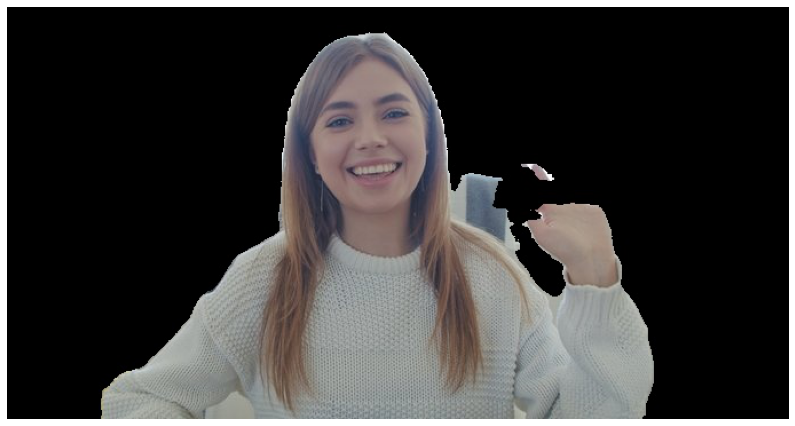

In [ ]:
plt.figure(figsize=(14,8))
image = mpimg.imread("Images/ver_2.jpg")
plt.axis('off')
plt.imshow(image)
plt.show()

## Tự đánh giá

### Từng thành viên

1. Võ Ngọc Minh
    - Khó khăn:
        - Môn lập trình song song ứng dụng này được mở khá lâu sau khi học môn lập trình song song nên hầu hết các kiến thức cũ em đã quên nên không thể ứng dụng hết.
        - Ứng dụng kiến thức được học vào việc nhân ma trận 3 chiều nên còn nhiều khó khăn.
    - Cơ hội:
        - Được áp dụng kiến thức được học vào thực tế.
        - Đồ án này giúp em hiểu hơn về cách vận hành của machine learing(thứ mà trước giờ em thấy khó hình dung).

2. Nguyễn Thị Anh Đào

### Nhóm
Nếu có thêm thời gian, nhóm sẽ:
- Áp dụng shared memory cho toàn bộ các hàm để tốc ưu tốc độ xử lý hơn nữa.
- Áp dụng giảm warp divergence để tăng tốc độ xử lý của chính hàm song song.


## Tham khảo
Phần code tuần tự:
1. https://betterdatascience.com/implement-pooling-from-scratch-in-python/
2. https://d2l.ai/chapter_computer-vision/transposed-conv.html
3. http://d2l.ai/chapter_convolutional-modern/batch-norm.html?highlight=batchnorm

Phần code song song:


Ngoài ra:
https://www.kaggle.com/getting-started/253300

